# 🎤 Vocal Technique Recognition 🗣️
## Final Report (MIE1517 Introduction to Deep Learning) - Team 20

Steven Kim (1002071134), Tabitha Kim (1006788736), Kwansoo Lee (1012855830), Taeyoung Lee (1009781791)

You can also review our project in our Github page
[Fianl-Report_Team20](https://github.com/stevekslee/MIE1517-2025-Fall---Final-Report-Team20-)

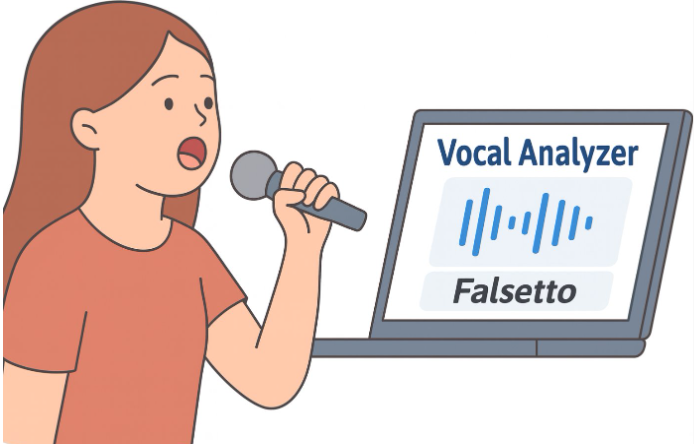

*Figure 0. Image generated by [ChatGPT](https://chatgpt.com/)*

## 1. Brief Description of the Project

This project focuses on **Vocal Technique Recognition** using deep learning and PyTorch. The goal is to automatically classify different vocal singing techniques from audio recordings, which has applications in music education, vocal training, and audio analysis.

Vocal technique recognition is a challenging audio classification task that requires understanding subtle differences in how singers produce sounds. Traditional approaches to analyzing vocal techniques often require expert knowledge and manual annotation, but deep learning enables automated classification of these nuanced audio patterns. This project demonstrates how modern audio representation learning models can be effectively applied to recognize six distinct vocal techniques: Breathy, Glissando, Pharyngeal, Vibrato, Falsetto, and Mixed Voice.

### Introduction to Vocal Technique Recognition

Vocal techniques are specific methods singers use to produce different sounds and express emotions. Each technique involves subtle variations in vocal cord vibration, breath control, and resonance that create distinct acoustic signatures. For example:
- **Breathy**: Produces a soft, airy quality by allowing excess air to escape
- **Falsetto**: Uses a higher register with lighter vocal cord vibration
- **Vibrato**: Creates a slight pitch oscillation for expressiveness
- **Glissando**: Involves smooth pitch transitions between notes
- **Pharyngeal**: Uses throat resonance for a specific timbre
- **Mixed Voice**: Combines chest and head voice registers

The challenge lies in capturing these nuanced differences from raw audio waveforms, where techniques may overlap and vary across singers, languages, and musical contexts.

### The Dataset: GTSinger

This project uses the **GTSinger** dataset [Zhang et al., 2024](https://arxiv.org/pdf/2409.13832), which addresses the scarcity of high-quality, multi-technique singing datasets. GTSinger provides:
- **80.59 hours** of high-quality studio-recorded singing voices (the largest recorded singing dataset)
- **20 professional singers** across **9 languages** (Chinese, English, Japanese, Korean, Russian, Spanish, French, German, Italian)
- **Phoneme-level annotations** for six singing techniques with controlled comparison groups
- **Realistic music scores** for real-world composition scenarios
- **Manual alignments** and style labels for comprehensive annotations

Each song in GTSinger includes both a control group (natural singing) and a technique group (intensive technique application) under the same lyrics. Here, we use only a technique group to capture the features in more realistic singing, allowing the model to learn broader stylistic patterns.

**Dataset Access**: The GTSinger dataset can be downloaded from [Google Drive](https://drive.google.com/file/d/16l-M4Dav5GZPvXYKFe27_KId3hsjNFDV/view?usp=sharing). The full dataset is also available through the official repository and paper. For this project, we use a subset of the dataset focusing on the six vocal techniques mentioned above. The dataset used for training is curated and described in section 4.

### Project Overview and Pipeline

The overall approach combines transfer learning with a pre-trained audio representation model (MERT) and a lightweight classification head. The pipeline, illustrated in Figure 1 below, consists of three main stages: (1) audio pre-processing and normalization, (2) feature extraction using a frozen MERT backbone, and (3) classification using a trainable 1D-CNN head. This approach enables efficient training while leveraging rich audio representations learned from large-scale music datasets.

## 2. Approach

### How to Solve the Problem

Vocal technique recognition can be approached in several ways:

1. **End-to-End Learning**: Training a model from scratch on raw audio waveforms or spectrograms
2. **Traditional Feature Engineering**: Using handcrafted features (MFCCs, chroma, spectral features) with classical ML classifiers
3. **Transfer Learning**: Leveraging pre-trained audio representation models as feature extractors
4. **Hybrid Approaches**: Combining multiple feature types or ensemble methods

Each approach has trade-offs. End-to-end learning requires large datasets and computational resources. Traditional features may miss complex patterns. Transfer learning balances efficiency and performance by leveraging representations learned from large-scale music datasets.

### The Strategy We Are Going to Use

This project implements vocal technique classification using a **transfer learning approach** with a pre-trained audio representation model. The strategy consists of three main stages:

- **Data Pre-processing**: Raw audio from the GTSinger dataset is normalized (converted to mono, resampled to 24 kHz to match MERT's requirements, and padded/truncated to fixed length) and split into train/validation/test sets (70%/15%/15%)

- **Feature Extraction with MERT**: A frozen MERT (Music Audio Representation Transformer) backbone extracts high-level audio features. MERT outputs frame-level embeddings (1024-dimensional vectors) that encode pitch, timbre, and temporal context of the vocal performance

- **Classification Head**: Three alternative classifier architectures were evaluated to process the sequence of MERT embeddings:
  - **1D-CNN Classifier** (primary): A lightweight 1D convolutional neural network with the following architecture:
    - **Temporal Conv1D layer**: Kernel size 5, reduces feature dimension from 1024 → 128 channels, followed by BatchNorm1d, GELU activation, and Dropout (p=0.3)
    - **Global Average Pooling**: Aggregates the temporal dimension to produce a single 128-dimensional vector per audio clip
    - **Fully Connected layers**: Two linear layers (128 → 64, then 64 → 6) with GELU activation and Dropout (p=0.3) between them, producing logits for the 6 technique classes
    - **Tensor flow**: MERT outputs [B, T, 1024] frame-level embeddings → Conv1D produces [B, T, 128] → Global Average Pooling yields [B, 128] → FC layers output [B, 6] logits
  - **CRNN Classifier**: A Convolutional Recurrent Neural Network combining 1D convolutions with LSTM layers for temporal modeling
  - **Transformer Classifier**: A Transformer-based architecture using self-attention mechanisms to capture long-range temporal dependencies
  - **Classifier Selection**: After evaluating all three architectures, the 1D-CNN classifier was selected as the final model due to its superior performance on the validation set. The 1D-CNN achieved the best balance between accuracy and computational efficiency, demonstrating that the temporal patterns in MERT embeddings can be effectively captured through lightweight convolutional operations without the added complexity of recurrent layers or self-attention mechanisms. This finding suggests that the frame-level features extracted by MERT already encode sufficient temporal context, making a simple temporal convolution sufficient for the classification task.

### Why This Approach Works

The key innovation in this project is the use of a frozen pre-trained MERT model as a feature extractor, combined with a lightweight trainable classification head. This transfer learning approach offers several advantages:

1. **Efficiency**: By freezing MERT, we leverage rich audio representations learned from large-scale music datasets without retraining the entire model
2. **Data Efficiency**: Requires minimal training data and computational resources compared to training from scratch
3. **Generalization**: Pre-trained representations capture universal audio patterns that transfer well to the specific task of vocal technique recognition
4. **Flexibility**: The lightweight classification head can be easily swapped or modified to experiment with different architectures

### Loss Function We Optimize

For this multi-class classification task, we use **Cross-Entropy Loss** (also known as **Categorical Cross-Entropy** or **Softmax Loss**), which is the standard loss function for classification problems with multiple mutually exclusive classes.

**Mathematical Formulation:**

Given a batch of predictions (logits) from our model and the true class labels, the cross-entropy loss is computed as:

$$\mathcal{L}_{CE} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$$

where:
- $N$ is the batch size
- $C$ is the number of classes (6 in our case: Breathy, Glissando, Pharyngeal, Vibrato, Falsetto, Mixed Voice)
- $y_{i,c}$ is the true label (1 if sample $i$ belongs to class $c$, 0 otherwise) - this is a one-hot encoded vector
- $\hat{y}_{i,c}$ is the predicted probability that sample $i$ belongs to class $c$, computed using the softmax function:

$$\hat{y}_{i,c} = \frac{\exp(z_{i,c})}{\sum_{j=1}^{C}\exp(z_{i,j})}$$

where $z_{i,c}$ are the raw logits (unnormalized scores) output by the final linear layer of our classifier.

**Why Cross-Entropy Loss?**

1. **Probabilistic Interpretation**: Cross-entropy loss measures the difference between the predicted probability distribution and the true distribution. It encourages the model to output high confidence for the correct class and low confidence for incorrect classes.

2. **Numerical Stability**: PyTorch's `CrossEntropyLoss` combines the softmax and negative log-likelihood operations in a numerically stable way, preventing overflow/underflow issues that can occur when computing exponentials of large logits.

3. **Gradient Properties**: The gradient of cross-entropy loss with respect to the logits has a simple form that provides strong learning signals, especially when predictions are wrong.

4. **Multi-Class Classification**: Unlike binary cross-entropy (used for binary classification), cross-entropy loss naturally handles multiple classes and ensures that the predicted probabilities sum to 1 across all classes.

In our implementation, the model outputs raw logits [B, 6] for each audio sample in the batch, and `nn.CrossEntropyLoss` internally applies softmax and computes the negative log-likelihood. The loss is then backpropagated to update the trainable parameters of the classification head.


**Evaluation Metrics**: Model performance is evaluated using accuracy (percentage of correctly classified samples) and cross-entropy loss on the validation and test sets. The confusion matrix is also computed to analyze per-class performance and identify any technique-specific challenges.


## 3. Implementation of The Vocal Technique Recognizer

### 3-1. Downloading the GTsinger Dataset

We processed the dataset by removing unnecessary files (musicxml, json and txt formats), leaving only `.wav` files for our project to reduce the size of the dataset. And we only used 'English' singing dataset from the original GTsinger dataset ([Google Drive](https://drive.google.com/file/d/16l-M4Dav5GZPvXYKFe27_KId3hsjNFDV/view?usp=sharing)) due to a training time limitation and memory issues.

 Please find the link [GTsinger Dataset - Team20](https://drive.google.com/file/d/11aQMAexLnb_Qdb232ytvW-W8ImTae6BC/view?usp=sharing) to download the used dataset for this project and put the zip file into the `data` folder. Then, the the right below code will unzip the file properly.

In [ ]:
import zipfile
from pathlib import Path

zip_path = Path("./data/GTsinger.zip")
extract_dir = Path("./data")

if not zip_path.exists():
    raise FileNotFoundError(f"Zip file not found: {zip_path}")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ GTsinger.zip extracted successfully into data/")

✅ GTsinger.zip extracted successfully into data/


### 3-2. Data Splitting Strategy

The primary goal of the data split was to ensure a balanced distribution of singing techniques (labels) across all singer IDs. To achieve this, the split was performed within each singer's samples, applying the defined ratios:
- **Train: 70%**
- **Validation: 15%**
- **Test: 15%**

In [ ]:
from collections import defaultdict
import random
import json
from pathlib import Path

# 1) Set the root directory
ROOT_DIR = Path("./data/GTsinger/English")
OUTPUT_JSON = ROOT_DIR / "metadata.json"
RANDOM_SEED = 42

# train/val/test dataset ratios
SPLIT_RATIOS = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15,
}

def technique_label(tech_folder: str, group_folder: str):
    # Basic techniques
    if tech_folder == "Breathy" and group_folder == "Breathy_Group":
        return "Breathy"
    if tech_folder == "Glissando" and group_folder == "Glissando_Group":
        return "Glissando"
    if tech_folder == "Pharyngeal" and group_folder == "Pharyngeal_Group":
        return "Pharyngeal"
    if tech_folder == "Vibrato" and group_folder == "Vibrato_Group":
        return "Vibrato"
    if tech_folder == "Mixed_Voice_and_Falsetto":
        if group_folder == "Falsetto_Group":
            return "Falsetto"
        if group_folder == "Mixed_Voice_Group":
            return "Mixed_Voice"
        return None

    return None

random.seed(RANDOM_SEED)

# samples_by_singer[label][singer_id] = [sample, sample, ...]
samples_by_singer = defaultdict(lambda: defaultdict(list))

# 2) Walk through all files
for wav in ROOT_DIR.rglob("*.wav"):
    # skip MacOS junk
    if "__MACOSX" in wav.parts:
        continue

    # make path relative to ROOT_DIR
    rel = wav.relative_to(ROOT_DIR)
    # [singer_id, tech_folder, song_title, group_folder, filename]
    parts = rel.parts

    if len(parts) != 5:
        print("Skipping unexpected path:", rel)
        continue

    singer_id, tech_folder, song_title, group_folder, filename = parts

    label = technique_label(tech_folder, group_folder)
    if label is None:
        continue

    sample = {
        "filepath": str(wav),
        "singer_id": singer_id,
        "tech_folder": tech_folder,
        "song_title": song_title,
        "group_folder": group_folder,
        "filename": filename,
        "technique": label,
    }

    samples_by_singer[label][singer_id].append(sample)

# 3) Split into Train, Valid, and Test
splits = {"train": [], "val": [], "test": []}

for label, singer_dict in samples_by_singer.items():
    for singer_id, samples in singer_dict.items():
        random.shuffle(samples)

        n = len(samples)
        n_train = int(n * SPLIT_RATIOS["train"])
        n_val = int(n * SPLIT_RATIOS["val"])
        n_test = n - n_train - n_val

        splits["train"].extend(samples[:n_train])
        splits["val"].extend(samples[n_train:n_train + n_val])
        splits["test"].extend(samples[n_train + n_val:])

# 4) Save a meta json file
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=4, ensure_ascii=False)

print(f"Saved metadata to {OUTPUT_JSON}")

Saved metadata to data/GTsinger/English/metadata.json


### 3-3. Visualization of dataset

We perform the visualization the loaded dataset. The absolute number of training, validation, and test samples for each singer illustrates the data distribution across singer IDs. Also, as shown in the number of samples per split, the data is well split into the defined ratios. While the Mixed_Voice and Falsetto classes contain approximately twice as many samples as the other techniques, we intentionally did not downsample them to prevent unnecessary information loss, and to keep the dataset representative of the original dataset.

=== Dataset Summary ===
train     : 1925 samples
val       : 405 samples
test      : 432 samples


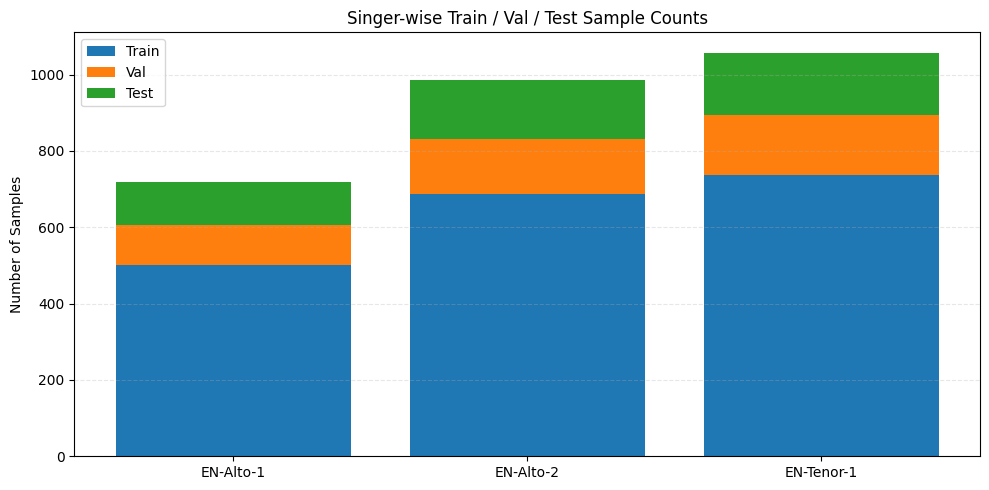


=== Number of Samples per Split ===


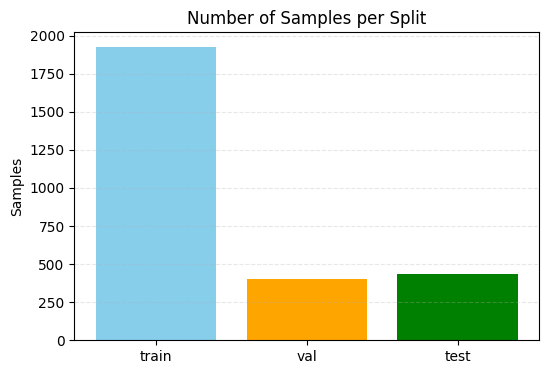


=== Class Distribution: TRAIN ===
Breathy         :  252
Falsetto        :  486
Glissando       :  246
Mixed_Voice     :  488
Pharyngeal      :  243
Vibrato         :  210


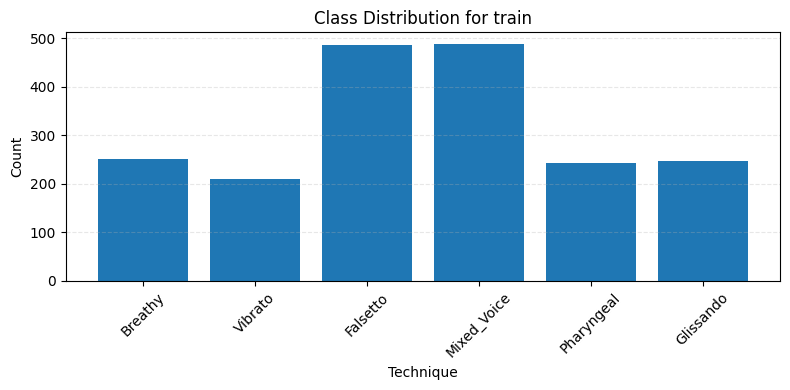


=== Class Distribution: VAL ===
Breathy         :   53
Falsetto        :  103
Glissando       :   51
Mixed_Voice     :  103
Pharyngeal      :   51
Vibrato         :   44


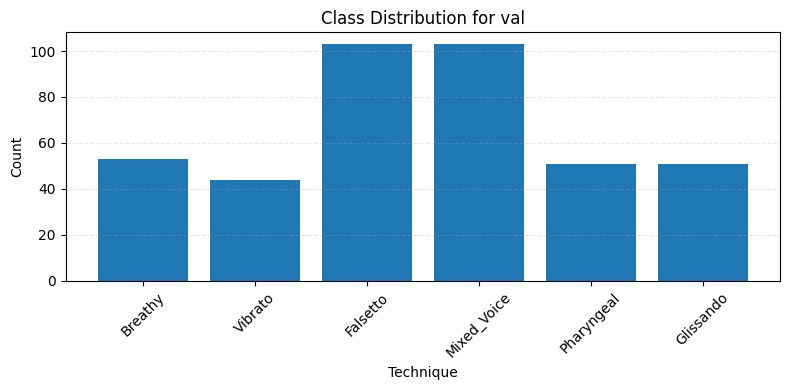


=== Class Distribution: TEST ===
Breathy         :   56
Falsetto        :  108
Glissando       :   56
Mixed_Voice     :  109
Pharyngeal      :   55
Vibrato         :   48


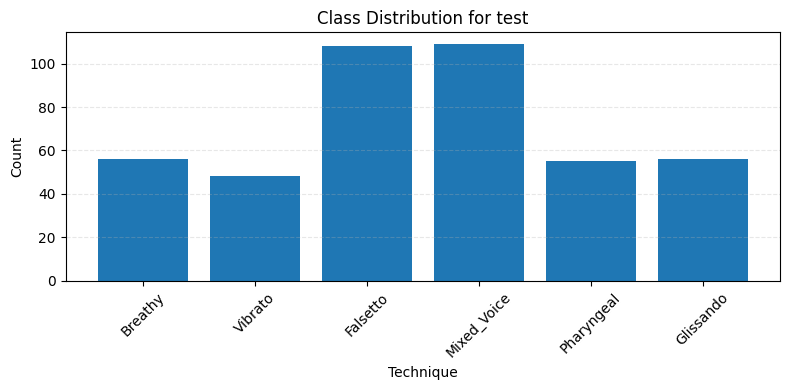

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metadata_file = "./data/GTsinger/English/metadata.json"
splits = ["train", "val", "test"]

# Load metadata
meta_path = Path(metadata_file)
with open(meta_path, "r", encoding="utf-8") as f:
    all_meta = json.load(f)

print("=== Dataset Summary ===")

# Count samples per split
split_counts = {}
for split in splits:
    if split in all_meta:
        split_counts[split] = len(all_meta[split])
        print(f"{split:<10}: {len(all_meta[split])} samples")
    else:
        print(f"{split:<10}: NOT FOUND in metadata.json")

# singer_id -> [train, val, test]
singer_split_counts = defaultdict(lambda: {"train": 0, "val": 0, "test": 0})

for split in ["train", "val", "test"]:
    for item in all_meta[split]:
        singer_split_counts[item["singer_id"]][split] += 1

singers = sorted(singer_split_counts.keys())

train_counts = np.array([singer_split_counts[s]["train"] for s in singers])
val_counts   = np.array([singer_split_counts[s]["val"]   for s in singers])
test_counts  = np.array([singer_split_counts[s]["test"]  for s in singers])

# --- Plot (ABSOLUTE COUNTS) ---
plt.figure(figsize=(10, 5))

plt.bar(singers, train_counts, label="Train")
plt.bar(singers, val_counts,  bottom=train_counts, label="Val")
plt.bar(singers, test_counts, bottom=train_counts + val_counts, label="Test")

plt.ylabel("Number of Samples")
plt.title("Singer-wise Train / Val / Test Sample Counts")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot split distribution ---
print(f"\n=== Number of Samples per Split ===")
plt.figure(figsize=(6, 4))
plt.bar(split_counts.keys(), split_counts.values(), color=["skyblue", "orange", "green"])
plt.title("Number of Samples per Split")
plt.ylabel("Samples")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

# --- Class distribution per split ---
for split in splits:
    if split not in all_meta:
        continue

    print(f"\n=== Class Distribution: {split.upper()} ===")
    items = all_meta[split]

    class_counts = defaultdict(int)
    for m in items:
        class_counts[m["technique"]] += 1

    # Print counts
    for tech, cnt in sorted(class_counts.items()):
        print(f"{tech:<15} : {cnt:4d}")

    # Bar chart
    plt.figure(figsize=(8, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"Class Distribution for {split}")
    plt.xlabel("Technique")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

### 3-4. Model Architecture

Our end-to-end pipeline consists of three main stages:

- (1) Data pre-processing  

- (2) Feature extraction with a frozen MERT backbone

- (3) Lightweight 1D-CNN classification head.

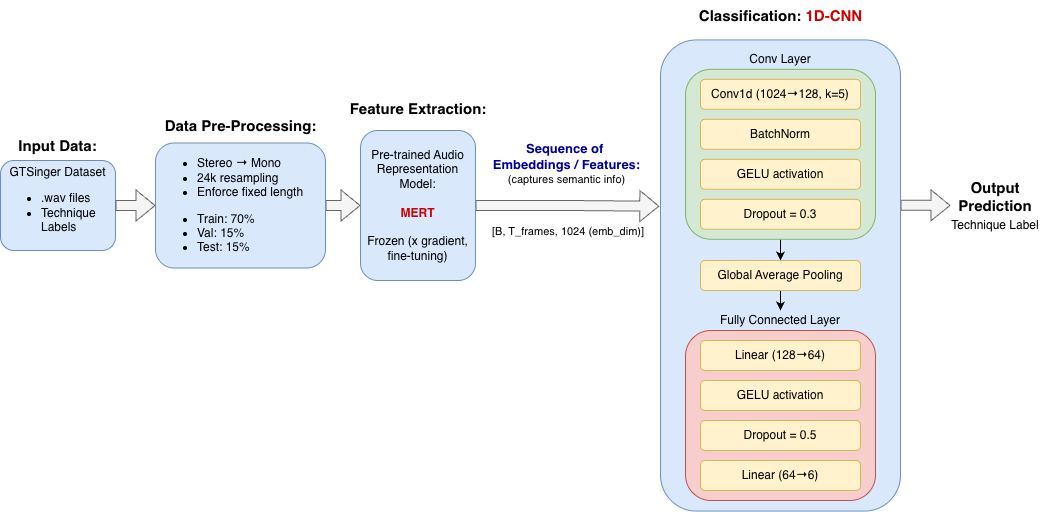
*Figure 1. Overall pipeline*


#### Data Pre-Processing

The raw audio is normalized into a consistent format before feature extraction:

- All audio is resampled to **24 kHz** and converted to **mono**

- **Amplitude normalization** using max absolute value

- Fixed **10-second duration** via truncation or zero-padding

This produces uniformly shaped audio tensors that can be fed into the pre-trained audio model.

#### Feature Extraction with MERT

For our transfer learning task we use **MERT**, a large pre-trained audio representation model.  
MERT is kept **frozen** (no gradient updates) and only used as a feature extractor.

Given a batch of pre-processed audio:

- MERT outputs a **sequence of embeddings**:

  $$
  \text{MERT}(x) \rightarrow \mathbf{Z} \in \mathbb{R}^{B \times T_{\text{frames}} \times 1024}
  $$

  where:
  - $B$ = batch size  
  - $T_{\text{frames}}$ = number of time frames  
  - 1024 = embedding dimension for each frame

Intuitively, each 1024-dimensional vector encodes high-level information about the pitch, timbre, and temporal context of the vocal performance.

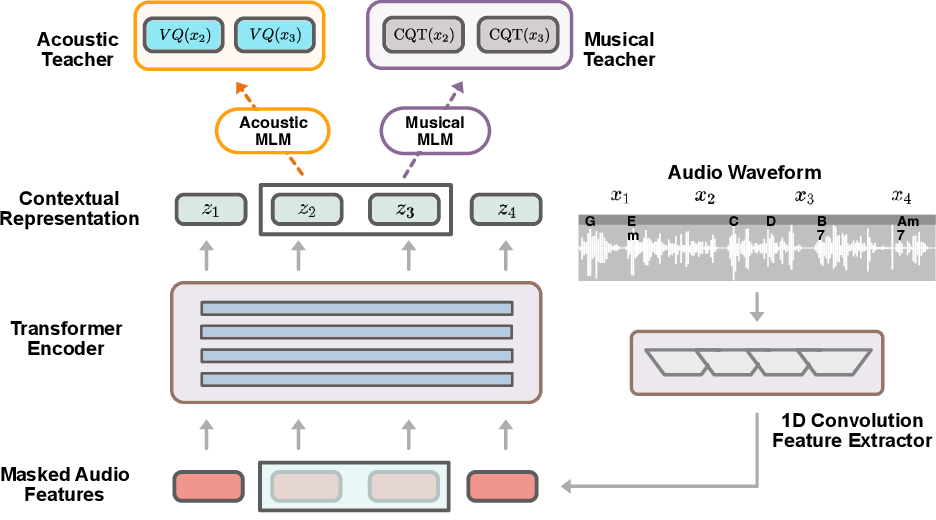

*Figure 2. MERT architecture*<sup>*</sup>

<sup>*</sup> Li, Yizhi, et al. "Mert: Acoustic music understanding model with large-scale self-supervised training." arXiv preprint arXiv:2306.00107 (2023).


#### 1D-CNN Classification Head


The sequence of MERT embeddings is then fed into a **1D-CNN** that performs the final technique classification.  
The CNN only operates in the *feature* space (over time), not directly on raw waveforms.

The head consists of:

① **Temporal Conv1D block**
   - Conv1D with kernel size \(k = 5\), input channels 1024 and output channels 128  
   - BatchNorm  
   - GELU activation  
   - Dropout \( p = 0.3 \)

   This layer reduces each frame’s feature dimension from **1024 → 128** while allowing the model to look at short temporal neighborhoods.

② **Global Average Pooling (GAP) over time**
   - Aggregates the sequence of frame-wise features into a **single 128-D vector** per clip:

  $$
  \mathbb{R}^{B \times T \times 128} \rightarrow \mathbb{R}^{B \times 128}
  $$

   - This makes the classifier robust to variable-length inputs and focuses on the overall technique rather than frame-level noise.

③ **Fully Connected (FC) head**
   - Linear **128 → 64**  
   - GELU activation  
   - Dropout \( p = 0.5 \)  
   - Final Linear **64 → 6** (one logit per technique class)

The final 6-dimensional logit vector is passed through a softmax at inference time to produce the **predicted technique label** for each input clip.

#### Comparison of Classifier Architectures

| Classifier      | Temporal modeling              | Complexity          | Outcome in our project                               |
|-----------------|--------------------------------|---------------------|------------------------------------------------------|
| **1D-CNN**      | Conv1D over frames + GAP       | Low (few params)    | Best validation performance; chosen as final model.  |
| **CRNN**        | Conv1D front-end + BiLSTM      | Medium–High         | Some overfitting; no clear gain over 1D-CNN.         |
| **Transformer** | Self-attention over all frames | High (most params)  | Slowest and least stable; did not beat 1D-CNN.       |

**Qualitative strengths and limitations**

- **1D-CNN:** Fast to train/infer, stable optimization, captures local temporal patterns well; less explicit global context.
- **CRNN:** Can model both local patterns (conv) and longer-term structure (LSTM); heavier and showed larger train–val gap on our dataset.
- **Transformer:** Very flexible global context modeling in principle; highest computational cost and parameters, and training was slower and less stable for our data size.

This still gives a clear comparison, but the table itself is narrow enough to fit comfortably in one view.

### 3-5. Loading and Pre-processing Audio Dataset

To verify our transfer learning approach with MERT is suitable for this project, we include two types of feature extraction modes.

**1) Mel Spectrogram Mode:**

- 128 mel features

- FFT size = 2048, hop length = 512

- Frequency range: 50–8000 Hz

- Log-power compression + per-sample z-score normalization

- Output shape: [T,128]


**2) MERT Mode:**

- 1028 MERT features

- The pre-processed waveform input to pretrained MERT

- Features are extracted as described above.

- Output feature shape: [T,1024]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModel
from typing import Optional, Literal
import librosa
import soundfile as sf
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
import os
import csv

class GTsingerAudioDataset(Dataset):
    """
    Dataset for GTsinger technique recognition

    mode = "mert"  -> returns MERT features:   [T, 1024]
    mode = "mel"   -> returns Mel spectrogram: [1, T, n_mels]
    """

    def __init__(
        self,
        metadata_file: str,
        split: str,
        mode: Literal["mert", "mel"] = "mert",

        # MERT-related (required if mode == "mert")
        mert_processor=None,
        mert_model=None,

        # Mel-spectrogram related (used if mode == "mel")
        n_mels: int = 128,

        # Audio settings
        max_length_sec: float = 10.0,
        target_sr: int = 24000,
        data_root: Optional[str] = None,

        seed: int = 42,
    ):
        # Reproducibility
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)

        assert mode in ["mert", "mel"], "mode must be 'mert' or 'mel'"
        self.mode = mode
        self.mert_processor = mert_processor
        self.mert_model = mert_model
        self.n_mels = n_mels
        self.max_length_sec = max_length_sec
        self.target_sr = target_sr

        # ---- metadata path ----
        metadata_path = Path(metadata_file)
        if not metadata_path.is_absolute():
            metadata_path = Path(metadata_file).absolute()

        with open(metadata_path, "r", encoding="utf-8") as f:
            all_meta = json.load(f)

        if split not in all_meta:
            raise ValueError(
                f"Split '{split}' not found in {metadata_path}. "
                f"Available splits: {list(all_meta.keys())}"
            )

        all_samples = []
        for k, v in all_meta.items():
            if isinstance(v, list):
                all_samples.extend(v)

        techniques = sorted({m["technique"] for m in all_samples})
        self.technique_map = {tech: idx for idx, tech in enumerate(techniques)}
        self.idx_to_tech = {idx: tech for tech, idx in self.technique_map.items()}
        self.num_classes = len(self.technique_map)

        # print("[Dataset] Technique → index mapping:")
        # for tech, idx in self.technique_map.items():
        #     print(f"  {tech:<15} -> {idx}")

        # ---- split based on medadata ----
        self.metadata = all_meta[split]
        self.split = split

        # ---- data_root ----
        if data_root is not None:
            self.data_root = Path(data_root)
        else:
            self.data_root = Path(".").absolute()

        print(f"[Dataset] Split '{split}': {len(self.metadata)} samples")

        if self.mode == "mert":
            assert self.mert_processor is not None and self.mert_model is not None, \
                "mert_processor and mert_model are required when mode='mert'"

    def _resolve_audio_path(self, rel_or_abs: str) -> Path:
        p = Path(rel_or_abs)
        if p.is_absolute():
            return p
        return self.data_root / p

    def _load_and_fix_length(self, audio_path: Path) -> np.ndarray:
        try:
            audio, sr = librosa.load(str(audio_path), sr=self.target_sr, mono=True)

            # amplitude normalize
            if audio.max() > 0:
                audio = audio / np.abs(audio).max()

            target_len = int(self.max_length_sec * self.target_sr)
            if audio.shape[0] > target_len:
                audio = audio[:target_len]
            elif audio.shape[0] < target_len:
                audio = np.pad(audio, (0, target_len - audio.shape[0]), mode="constant")

        except Exception as e:
            print(f"[Dataset:{self.split}] Error loading {audio_path}: {e}")
            audio = np.random.randn(int(self.max_length_sec * self.target_sr)).astype(np.float32)

        return audio.astype(np.float32)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        meta = self.metadata[idx]
        filepath = meta["filepath"]
        audio_path = self._resolve_audio_path(filepath)
        audio = self._load_and_fix_length(audio_path)

        # Labels
        tech_name = meta["technique"]
        if tech_name not in self.technique_map:
            raise ValueError(f"Unknown technique '{tech_name}' in meta.json")
        label = torch.tensor(self.technique_map[tech_name], dtype=torch.long)

        # 1) Mel spectrogram (without a pretrained model)
        if self.mode == "mel":
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=self.target_sr,
                n_fft=2048,
                hop_length=512,
                n_mels=self.n_mels,
                fmin=50,
                fmax=8000,
            )
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # per-sample normalize
            mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

            # mel_spec: numpy [n_mels, time]
            mel_spec = torch.from_numpy(mel_spec).float()   # [n_mels, T]
            mel_spec = mel_spec.transpose(0, 1)             # [T, n_mels]

            return {
                "features": mel_spec,   # [T, n_mels]
                "label": label,
                "filepath": filepath,
            }

        # 2) MERT processor (with a pretrained model)
        elif self.mode == "mert":
            with torch.no_grad():
                inputs = self.mert_processor(
                    audio,
                    sampling_rate=self.target_sr,
                    return_tensors="pt",
                )
                # device
                inputs = {k: v.to(self.mert_model.device) for k, v in inputs.items()}
                hidden_states = self.mert_model(**inputs).last_hidden_state  # [1, T, 1024]

            return {
                "features": hidden_states.squeeze(0),  # [T, 1024]
                "label": label,
                "filepath": filepath,
            }

/home/steve/anaconda3/envs/DL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3-6. Vocal Technique Recognizers (Classifier Models)

We train three classifiers to select the best classification models at the end. These models classify the techniques of voice recordings that are preprocessed through Mel Spectrogram or the MERT model.

**1) 1D-CNN Classifier:**
- Operates on frame-level sequential features extracted from Mel Spectrograms or MERT (`input shape: [B,T,F]`)

- Applies a 1D convolution over the temporal axis to capture short-term temporal patterns

- Uses:

  - 1D Convolution with kernel size 5

  - Batch Normalization for training stability

  - GELU activation for non-linearity

  - Dropout for regularization

  - Global average pooling over time converts variable-length sequences into a fixed-length vector

  - A fully connected classifier head maps hidden features to the final technique classes

  - Designed for lightweight and efficient temporal modeling

In [ ]:
class CNN1D_Classifier(nn.Module):
    """
    1D CNN classifier over time for frame-level features.
    """
    def __init__(self, in_channels, hidden=128, kernel_size=5, n_classes=6, dropout=0.3):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels, hidden, kernel_size=kernel_size,
                      padding=kernel_size // 2),
            nn.BatchNorm1d(hidden),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, n_classes),
        )

    def forward(self, z_btf: torch.Tensor):
        # z_btf: [B, T, F]
        x = z_btf.transpose(1, 2)      # [B, F, T]
        x = self.conv_layers(x)        # [B, hidden, T]
        x = x.mean(dim=2)              # [B, hidden]
        return self.classifier(x)      # [B, n_classes]

**2) Convolutional Recurrent Neural Network Classifier:**
- Designed to jointly model short-term spectral patterns and long-term temporal dynamics

- Operates on frame-level sequential features from Mel Spectrograms or MERT (`input shape: [B,T,F]`)

- First applies a 1D temporal convolution to extract local temporal patterns

- Convolution Uses:

  - Kernel size 5 with padding

  - Batch Normalization + GELU activation

  - Dropout for regularization

The convolutional features are then forwarded to a Bidirectional LSTM.

- LSTM Uses:

  - Captures long-term temporal dependencies

  - Uses a two-layer stacked Bidirectional LSTM to capture long-term temporal dependencies

The bidirectional LSTM output is globally averaged over time.

Then, a fully connected classifier head maps the aggregated temporal features to the final technique classes.

In [ ]:
class CRNN_Classifier(nn.Module):
    """
    CRNN classifier over time for frame-level features.
    """
    def __init__(self, in_channels, cnn_hidden=128, rnn_hidden=128, rnn_layers=2, n_classes=6, dropout=0.3):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, cnn_hidden, kernel_size=5, padding=2),
            nn.BatchNorm1d(cnn_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        self.rnn = nn.LSTM(
            input_size=cnn_hidden,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if rnn_layers > 1 else 0.0,
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(rnn_hidden * 2, n_classes),
        )

    def forward(self, z_btf: torch.Tensor):
        # z_btf: [B, T, F]
        x = z_btf.transpose(1, 2)      # [B, F, T]
        x = self.conv(x)               # [B, cnn_hidden, T]
        x = x.transpose(1, 2)          # [B, T, cnn_hidden]
        x, _ = self.rnn(x)             # [B, T, 2*rnn_hidden]
        x = x.mean(dim=1)              # [B, 2*rnn_hidden]
        return self.classifier(x)      # [B, n_classes]

**3) Transformer Classifier:**
  - Applies a linear input projection to map frame-level features 𝐹 into the Transformer embedding dimension
 to model global temporal dependencies across the entire time sequence using self-attention

  - Uses a single-layer Transformer Encoder with:

    - Multi-head self-attention (𝑛ℎ𝑒𝑎𝑑 = 4)

    - Feed-forward network with hidden size 2 × 𝑑<sub>𝑚𝑜𝑑𝑒𝑙</sub>

Then, global average pooling over time is performed to obtain a fixed-length representation

A fully connected classifier head maps the the pooled temporal features to the final technique classes.

In [ ]:
class Transformer_Classifier(nn.Module):
    """
    Transformer classifier over time for frame-level features.
    """
    def __init__(self, in_channels, d_model=128, nhead=4, n_classes=6, dropout=0.3):
        super().__init__()

        self.input_proj = nn.Linear(in_channels, d_model)  # F -> d_model

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, n_classes),
        )

    def forward(self, z_btc: torch.Tensor):
        # z_btc: [B, T, F]
        x = self.input_proj(z_btc)      # [B, T, d_model]
        x = self.transformer(x)         # [B, T, d_model]
        x = x.mean(dim=1)               # global average over time -> [B, d_model]
        return self.classifier(x)       # [B, n_classes]

### 3-7. Train Helpers

- plot_history:
  Visualizes these metrics by saving loss and accuracy curves as `.PNG` files.

- save_history_csv:
Stores the training and validation loss and accuracy for each epoch in a `.CSV` file.

- run_epoch:
Performs one epoch of training or validation depending on the mode. In training mode, the model computes the loss, backpropagates gradients, and updates the network parameters using the optimizer. In validation mode, the model only performs forward inference without gradient updates. For both modes, the function computes and returns the average loss and classification accuracy over the entire dataset.


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, results_dir: Path):
    results_dir = Path(results_dir)
    results_dir.mkdir(parents=True, exist_ok=True)

    epochs = history["epoch"]

    # Loss curve
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(results_dir / "loss_curve.png", dpi=150)
    plt.close()

    # Accuracy curve
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(results_dir / "accuracy_curve.png", dpi=150)
    plt.close()

def save_history_csv(history, results_dir: Path):
    results_dir = Path(results_dir)
    csv_path = results_dir / "metrics_history.csv"

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
        for i in range(len(history["epoch"])):
            writer.writerow([
                history["epoch"][i],
                history["train_loss"][i],
                history["train_acc"][i],
                history["val_loss"][i],
                history["val_acc"][i],
            ])

def run_epoch(model, dataloader, criterion, optimizer, device, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Train" if train else "Val", leave=False):
        features = batch["features"].to(device)   # [B, T, F]
        labels = batch["label"].to(device)        # [B]

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(features)              # [B, n_classes]
            loss = criterion(logits, labels)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / max(1, len(dataloader))
    acc = correct / max(1, total)
    return avg_loss, acc

### 3-8. Training Configuration
In train_gtsinger function, there are
- Mode Selection: Selects pre-training mode (Mel-spectrogram or MERT features, loading when `mode="mert"`)

- Dataset Loads: Builds training and validation dataaset from the metadata.json

- Model Initialization: initializes one of the three classifiers (CNN1D, CRNN, or Transformer)

- Optimizer and Loss Function: Uses Adam optimizer and Cross-Entropy Loss

- Dropout: Sets dropout rate as 0.3 to prevent overfitting

- Saving:
  - The best model based on validation loss for evaluation on the test dataset.
  - Intermediate checkpoints every 10 epochs
  - Training history as `CSV` and `PNG` for visualization of accuracy and loss curves

In [ ]:
def train_gtsinger(
    metadata_file: str,
    data_root: str,
    mode: str = "mel",        # "mel: no pre-trained model" or "mert: pre-trained model"
    model_type: str = "cnn",  # Classifiers ["cnn", "crnn", "transformer"]
    n_mels: int = 128,
    batch_size: int = 32,
    epochs: int = 100,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    dropout: float = 0.3,
    results_dir: str = "./results",
    seed: int = 42,
):

    # Reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    assert mode in ["mel", "mert"]
    assert model_type in ["cnn", "crnn", "transformer"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n=== Training GTsinger ({mode}, {model_type}) on {device} ===")

    # Pretrained model selection
    mert_processor, mert_model = None, None
    if mode == "mert":
        print("\nLoading MERT model...")
        model_name = "m-a-p/MERT-v1-330M"
        mert_processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        mert_model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        mert_model.to(device)
        mert_model.eval()
    else:
        print("\nMode = mel → MERT not loaded.")

    # Dataset / DataLoader
    metadata_file = str(metadata_file)
    data_root = str(data_root)

    print("\nCreating datasets...")
    train_dataset = GTsingerAudioDataset(
        metadata_file=metadata_file,
        split="train",
        mode=mode,
        mert_processor=mert_processor,
        mert_model=mert_model,
        n_mels=n_mels,
        max_length_sec=10.0,
        target_sr=24000,
        data_root=data_root,
    )

    val_dataset = GTsingerAudioDataset(
        metadata_file=metadata_file,
        split="val",
        mode=mode,
        mert_processor=mert_processor,
        mert_model=mert_model,
        n_mels=n_mels,
        max_length_sec=10.0,
        target_sr=24000,
        data_root=data_root,
    )

    # features shape: [T, F] → F
    sample_feat = train_dataset[0]["features"]   # [T, F]
    in_channels = sample_feat.shape[-1]
    n_classes = train_dataset.num_classes
    print(f"\nInput feature dim (F): {in_channels}")
    print(f"Num classes: {n_classes}")

    # Data loading reproducibility
    g = torch.Generator()
    g.manual_seed(seed)

    # DataLoaders - Batch
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
        generator=g
    )

    # Classifier Models
    print(f"\nInitializing {model_type.upper()} model...")

    if model_type == "cnn":
        model = CNN1D_Classifier(
            in_channels=in_channels,
            hidden=128,
            kernel_size=5,
            n_classes=n_classes,
            dropout=dropout,
        ).to(device)

    elif model_type == "crnn":
        model = CRNN_Classifier(
            in_channels=in_channels,
            cnn_hidden=128,
            rnn_hidden=128,
            rnn_layers=2,
            n_classes=n_classes,
            dropout=dropout,
        ).to(device)

    elif model_type == "transformer":
        model = Transformer_Classifier(
            in_channels=in_channels,
            d_model=128,
            nhead=4,
            n_classes=n_classes,
            dropout=dropout,
        ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")

    # Loss / Optim / Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=3, factor=0.5)

    # Results dir
    results_dir = Path(results_dir) / f"{mode}_{model_type}"
    results_dir.mkdir(parents=True, exist_ok=True)


    # Label mapping
    with open(results_dir / "label_mapping.json", "w", encoding="utf-8") as f:
        json.dump(train_dataset.idx_to_tech, f, indent=2)

    # Saving training history
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    best_val_loss = float("inf")
    best_model_path = results_dir / "best_model.pth"

    print(f"\nStart training for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss, train_acc = run_epoch(
            model, train_loader, criterion, optimizer, device, train=True
        )
        val_loss, val_acc = run_epoch(
            model, val_loader, criterion, optimizer, device, train=False
        )

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step(val_loss)

        # checkpoint every 10 epochs
        if epoch % 10 == 0:
          torch.save(model.state_dict(), results_dir / f"epoch_{epoch:03d}.pth")

        # best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✓ New best model saved (val_loss={best_val_loss:.4f})")

        # save csv/plot and update at every epoch
        save_history_csv(history, results_dir)
        plot_history(history, results_dir)

    print("\n=== Training finished ===")
    print(f"Best val loss: {best_val_loss:.4f}")
    print(f"Best model path: {best_model_path.resolve()}")

    epochs = history["epoch"]

    # Loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Accuracy curve
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model, history

**(1) Training [Mel Spectrogram] + [1DCNN Classifier]**


=== Training GTsinger (mel, cnn) on cuda ===

Mode = mel → MERT not loaded.

Creating datasets...
[Dataset] Split 'train': 1925 samples
[Dataset] Split 'val': 405 samples

Input feature dim (F): 128
Num classes: 6

Initializing CNN model...
Model parameters: 90,950

Results dir: /home/steve/final_report/train/GT_results/mel_cnn

Start training for 100 epochs...

Epoch 1/100


Train Loss: 1.4407, Train Acc: 0.4577
Val   Loss: 1.1635, Val   Acc: 0.5704
✓ New best model saved (val_loss=1.1635)

Epoch 2/100


Train Loss: 1.2070, Train Acc: 0.5273
Val   Loss: 1.0910, Val   Acc: 0.6025
✓ New best model saved (val_loss=1.0910)

Epoch 3/100


Train Loss: 1.1004, Train Acc: 0.5673
Val   Loss: 1.0108, Val   Acc: 0.6173
✓ New best model saved (val_loss=1.0108)

Epoch 4/100


Train Loss: 1.0369, Train Acc: 0.5891
Val   Loss: 0.9515, Val   Acc: 0.6346
✓ New best model saved (val_loss=0.9515)

Epoch 5/100


Train Loss: 1.0227, Train Acc: 0.6016
Val   Loss: 0.9200, Val   Acc: 0.6667
✓ New best model saved (val_loss=0.9200)

Epoch 6/100


Train Loss: 0.9753, Train Acc: 0.6088
Val   Loss: 0.9119, Val   Acc: 0.6420
✓ New best model saved (val_loss=0.9119)

Epoch 7/100


Train Loss: 0.9554, Train Acc: 0.6197
Val   Loss: 0.8983, Val   Acc: 0.6642
✓ New best model saved (val_loss=0.8983)

Epoch 8/100


Train Loss: 0.9316, Train Acc: 0.6384
Val   Loss: 0.8642, Val   Acc: 0.6691
✓ New best model saved (val_loss=0.8642)

Epoch 9/100


Train Loss: 0.9024, Train Acc: 0.6374
Val   Loss: 0.8363, Val   Acc: 0.6815
✓ New best model saved (val_loss=0.8363)

Epoch 10/100


Train Loss: 0.8870, Train Acc: 0.6582
Val   Loss: 0.8473, Val   Acc: 0.6617

Epoch 11/100


Train Loss: 0.8575, Train Acc: 0.6551
Val   Loss: 0.8181, Val   Acc: 0.6840
✓ New best model saved (val_loss=0.8181)

Epoch 12/100


Train Loss: 0.8568, Train Acc: 0.6494
Val   Loss: 0.8144, Val   Acc: 0.6864
✓ New best model saved (val_loss=0.8144)

Epoch 13/100


Train Loss: 0.8995, Train Acc: 0.6436
Val   Loss: 0.7983, Val   Acc: 0.6963
✓ New best model saved (val_loss=0.7983)

Epoch 14/100


Train Loss: 0.8468, Train Acc: 0.6868
Val   Loss: 0.8006, Val   Acc: 0.6889

Epoch 15/100


Train Loss: 0.8348, Train Acc: 0.6743
Val   Loss: 0.7857, Val   Acc: 0.7012
✓ New best model saved (val_loss=0.7857)

Epoch 16/100


Train Loss: 0.8165, Train Acc: 0.6696
Val   Loss: 0.7837, Val   Acc: 0.6889
✓ New best model saved (val_loss=0.7837)

Epoch 17/100


Train Loss: 0.7934, Train Acc: 0.6769
Val   Loss: 0.7544, Val   Acc: 0.7037
✓ New best model saved (val_loss=0.7544)

Epoch 18/100


Train Loss: 0.8142, Train Acc: 0.6868
Val   Loss: 0.7635, Val   Acc: 0.7111

Epoch 19/100


Train Loss: 0.8039, Train Acc: 0.6894
Val   Loss: 0.7303, Val   Acc: 0.7284
✓ New best model saved (val_loss=0.7303)

Epoch 20/100


Train Loss: 0.7660, Train Acc: 0.6904
Val   Loss: 0.7282, Val   Acc: 0.7235
✓ New best model saved (val_loss=0.7282)

Epoch 21/100


Train Loss: 0.7668, Train Acc: 0.7034
Val   Loss: 0.7159, Val   Acc: 0.7086
✓ New best model saved (val_loss=0.7159)

Epoch 22/100


Train Loss: 0.7608, Train Acc: 0.7070
Val   Loss: 0.7393, Val   Acc: 0.7012

Epoch 23/100


Train Loss: 0.7282, Train Acc: 0.7200
Val   Loss: 0.7271, Val   Acc: 0.7235

Epoch 24/100


Train Loss: 0.7563, Train Acc: 0.7200
Val   Loss: 0.7503, Val   Acc: 0.6889

Epoch 25/100


Train Loss: 0.7289, Train Acc: 0.7091
Val   Loss: 0.7239, Val   Acc: 0.7407

Epoch 26/100


Train Loss: 0.7063, Train Acc: 0.7268
Val   Loss: 0.6896, Val   Acc: 0.7309
✓ New best model saved (val_loss=0.6896)

Epoch 27/100


Train Loss: 0.6848, Train Acc: 0.7403
Val   Loss: 0.6718, Val   Acc: 0.7531
✓ New best model saved (val_loss=0.6718)

Epoch 28/100


Train Loss: 0.6538, Train Acc: 0.7517
Val   Loss: 0.6731, Val   Acc: 0.7383

Epoch 29/100


Train Loss: 0.6503, Train Acc: 0.7481
Val   Loss: 0.6651, Val   Acc: 0.7432
✓ New best model saved (val_loss=0.6651)

Epoch 30/100


Train Loss: 0.6673, Train Acc: 0.7543
Val   Loss: 0.6551, Val   Acc: 0.7531
✓ New best model saved (val_loss=0.6551)

Epoch 31/100


Train Loss: 0.6665, Train Acc: 0.7465
Val   Loss: 0.6437, Val   Acc: 0.7481
✓ New best model saved (val_loss=0.6437)

Epoch 32/100


Train Loss: 0.6691, Train Acc: 0.7584
Val   Loss: 0.6529, Val   Acc: 0.7284

Epoch 33/100


Train Loss: 0.6744, Train Acc: 0.7569
Val   Loss: 0.6781, Val   Acc: 0.7333

Epoch 34/100


Train Loss: 0.6498, Train Acc: 0.7574
Val   Loss: 0.6498, Val   Acc: 0.7605

Epoch 35/100


Train Loss: 0.6422, Train Acc: 0.7496
Val   Loss: 0.6456, Val   Acc: 0.7506

Epoch 36/100


Train Loss: 0.6022, Train Acc: 0.7730
Val   Loss: 0.6552, Val   Acc: 0.7506

Epoch 37/100


Train Loss: 0.6217, Train Acc: 0.7714
Val   Loss: 0.6387, Val   Acc: 0.7728
✓ New best model saved (val_loss=0.6387)

Epoch 38/100


Train Loss: 0.6490, Train Acc: 0.7481
Val   Loss: 0.6276, Val   Acc: 0.7679
✓ New best model saved (val_loss=0.6276)

Epoch 39/100


Train Loss: 0.5977, Train Acc: 0.7719
Val   Loss: 0.6355, Val   Acc: 0.7580

Epoch 40/100


Train Loss: 0.5874, Train Acc: 0.7730
Val   Loss: 0.6295, Val   Acc: 0.7531

Epoch 41/100


Train Loss: 0.5939, Train Acc: 0.7730
Val   Loss: 0.6404, Val   Acc: 0.7432

Epoch 42/100


Train Loss: 0.6109, Train Acc: 0.7579
Val   Loss: 0.6300, Val   Acc: 0.7679

Epoch 43/100


Train Loss: 0.5752, Train Acc: 0.7797
Val   Loss: 0.6229, Val   Acc: 0.7654
✓ New best model saved (val_loss=0.6229)

Epoch 44/100


Train Loss: 0.5824, Train Acc: 0.7797
Val   Loss: 0.6189, Val   Acc: 0.7605
✓ New best model saved (val_loss=0.6189)

Epoch 45/100


Train Loss: 0.5881, Train Acc: 0.7688
Val   Loss: 0.6283, Val   Acc: 0.7630

Epoch 46/100


Train Loss: 0.5895, Train Acc: 0.7823
Val   Loss: 0.6188, Val   Acc: 0.7605
✓ New best model saved (val_loss=0.6188)

Epoch 47/100


Train Loss: 0.5798, Train Acc: 0.7714
Val   Loss: 0.6194, Val   Acc: 0.7630

Epoch 48/100


Train Loss: 0.6017, Train Acc: 0.7699
Val   Loss: 0.6212, Val   Acc: 0.7654

Epoch 49/100


Train Loss: 0.5722, Train Acc: 0.7834
Val   Loss: 0.6145, Val   Acc: 0.7580
✓ New best model saved (val_loss=0.6145)

Epoch 50/100


Train Loss: 0.5623, Train Acc: 0.7787
Val   Loss: 0.6194, Val   Acc: 0.7630

Epoch 51/100


Train Loss: 0.5902, Train Acc: 0.7709
Val   Loss: 0.6200, Val   Acc: 0.7556

Epoch 52/100


Train Loss: 0.5766, Train Acc: 0.7777
Val   Loss: 0.6125, Val   Acc: 0.7630
✓ New best model saved (val_loss=0.6125)

Epoch 53/100


Train Loss: 0.5501, Train Acc: 0.7865
Val   Loss: 0.6205, Val   Acc: 0.7654

Epoch 54/100


Train Loss: 0.5748, Train Acc: 0.7912
Val   Loss: 0.6122, Val   Acc: 0.7605
✓ New best model saved (val_loss=0.6122)

Epoch 55/100


Train Loss: 0.5581, Train Acc: 0.7948
Val   Loss: 0.6264, Val   Acc: 0.7704

Epoch 56/100


Train Loss: 0.5816, Train Acc: 0.7969
Val   Loss: 0.6117, Val   Acc: 0.7679
✓ New best model saved (val_loss=0.6117)

Epoch 57/100


Train Loss: 0.5705, Train Acc: 0.7855
Val   Loss: 0.6159, Val   Acc: 0.7679

Epoch 58/100


Train Loss: 0.5668, Train Acc: 0.7886
Val   Loss: 0.6183, Val   Acc: 0.7605

Epoch 59/100


Train Loss: 0.5739, Train Acc: 0.7745
Val   Loss: 0.6121, Val   Acc: 0.7630

Epoch 60/100


Train Loss: 0.5423, Train Acc: 0.7964
Val   Loss: 0.6245, Val   Acc: 0.7580

Epoch 61/100


Train Loss: 0.5592, Train Acc: 0.7881
Val   Loss: 0.6194, Val   Acc: 0.7654

Epoch 62/100


Train Loss: 0.5347, Train Acc: 0.7953
Val   Loss: 0.6105, Val   Acc: 0.7630
✓ New best model saved (val_loss=0.6105)

Epoch 63/100


Train Loss: 0.5575, Train Acc: 0.7870
Val   Loss: 0.6196, Val   Acc: 0.7556

Epoch 64/100


Train Loss: 0.5594, Train Acc: 0.7870
Val   Loss: 0.6172, Val   Acc: 0.7704

Epoch 65/100


Train Loss: 0.5879, Train Acc: 0.7745
Val   Loss: 0.6130, Val   Acc: 0.7580

Epoch 66/100


Train Loss: 0.5486, Train Acc: 0.7896
Val   Loss: 0.6134, Val   Acc: 0.7679

Epoch 67/100


Train Loss: 0.5599, Train Acc: 0.8026
Val   Loss: 0.6103, Val   Acc: 0.7704
✓ New best model saved (val_loss=0.6103)

Epoch 68/100


Train Loss: 0.5741, Train Acc: 0.7922
Val   Loss: 0.6080, Val   Acc: 0.7605
✓ New best model saved (val_loss=0.6080)

Epoch 69/100


Train Loss: 0.5646, Train Acc: 0.7771
Val   Loss: 0.6078, Val   Acc: 0.7679
✓ New best model saved (val_loss=0.6078)

Epoch 70/100


Train Loss: 0.5666, Train Acc: 0.7881
Val   Loss: 0.6170, Val   Acc: 0.7728

Epoch 71/100


Train Loss: 0.5494, Train Acc: 0.7855
Val   Loss: 0.6163, Val   Acc: 0.7630

Epoch 72/100


Train Loss: 0.5384, Train Acc: 0.7912
Val   Loss: 0.6102, Val   Acc: 0.7654

Epoch 73/100


Train Loss: 0.5476, Train Acc: 0.7979
Val   Loss: 0.6096, Val   Acc: 0.7630

Epoch 74/100


Train Loss: 0.5500, Train Acc: 0.7834
Val   Loss: 0.6087, Val   Acc: 0.7605

Epoch 75/100


Train Loss: 0.5475, Train Acc: 0.7938
Val   Loss: 0.6042, Val   Acc: 0.7654
✓ New best model saved (val_loss=0.6042)

Epoch 76/100


Train Loss: 0.5498, Train Acc: 0.7990
Val   Loss: 0.6265, Val   Acc: 0.7704

Epoch 77/100


Train Loss: 0.5858, Train Acc: 0.7834
Val   Loss: 0.6042, Val   Acc: 0.7580
✓ New best model saved (val_loss=0.6042)

Epoch 78/100


Train Loss: 0.5585, Train Acc: 0.7797
Val   Loss: 0.6077, Val   Acc: 0.7728

Epoch 79/100


Train Loss: 0.5626, Train Acc: 0.7865
Val   Loss: 0.6118, Val   Acc: 0.7605

Epoch 80/100


Train Loss: 0.5498, Train Acc: 0.7823
Val   Loss: 0.6022, Val   Acc: 0.7654
✓ New best model saved (val_loss=0.6022)

Epoch 81/100


Train Loss: 0.5677, Train Acc: 0.7938
Val   Loss: 0.6164, Val   Acc: 0.7704

Epoch 82/100


Train Loss: 0.5476, Train Acc: 0.7896
Val   Loss: 0.6119, Val   Acc: 0.7704

Epoch 83/100


Train Loss: 0.5343, Train Acc: 0.7958
Val   Loss: 0.6117, Val   Acc: 0.7630

Epoch 84/100


Train Loss: 0.5439, Train Acc: 0.7901
Val   Loss: 0.6059, Val   Acc: 0.7630

Epoch 85/100


Train Loss: 0.5694, Train Acc: 0.7813
Val   Loss: 0.6032, Val   Acc: 0.7704

Epoch 86/100


Train Loss: 0.5654, Train Acc: 0.7870
Val   Loss: 0.6055, Val   Acc: 0.7679

Epoch 87/100


Train Loss: 0.5605, Train Acc: 0.7932
Val   Loss: 0.6071, Val   Acc: 0.7679

Epoch 88/100


Train Loss: 0.5681, Train Acc: 0.7886
Val   Loss: 0.6068, Val   Acc: 0.7630

Epoch 89/100


Train Loss: 0.5682, Train Acc: 0.7834
Val   Loss: 0.6136, Val   Acc: 0.7630

Epoch 90/100


Train Loss: 0.5369, Train Acc: 0.7995
Val   Loss: 0.6036, Val   Acc: 0.7630

Epoch 91/100


Train Loss: 0.5720, Train Acc: 0.7771
Val   Loss: 0.6081, Val   Acc: 0.7728

Epoch 92/100


Train Loss: 0.5248, Train Acc: 0.7995
Val   Loss: 0.6043, Val   Acc: 0.7654

Epoch 93/100


Train Loss: 0.5471, Train Acc: 0.7969
Val   Loss: 0.6089, Val   Acc: 0.7679

Epoch 94/100


Train Loss: 0.5667, Train Acc: 0.7927
Val   Loss: 0.6102, Val   Acc: 0.7679

Epoch 95/100


Train Loss: 0.5338, Train Acc: 0.8057
Val   Loss: 0.6072, Val   Acc: 0.7654

Epoch 96/100


Train Loss: 0.5679, Train Acc: 0.7787
Val   Loss: 0.6100, Val   Acc: 0.7704

Epoch 97/100


Train Loss: 0.5703, Train Acc: 0.7714
Val   Loss: 0.6057, Val   Acc: 0.7630

Epoch 98/100


Train Loss: 0.5309, Train Acc: 0.8052
Val   Loss: 0.6139, Val   Acc: 0.7704

Epoch 99/100


Train Loss: 0.5807, Train Acc: 0.7813
Val   Loss: 0.6034, Val   Acc: 0.7704

Epoch 100/100


Train Loss: 0.5745, Train Acc: 0.7751
Val   Loss: 0.6109, Val   Acc: 0.7728

=== Training finished ===
Best val loss: 0.6022
Best model path: /home/steve/final_report/train/GT_results/mel_cnn/best_model.pth


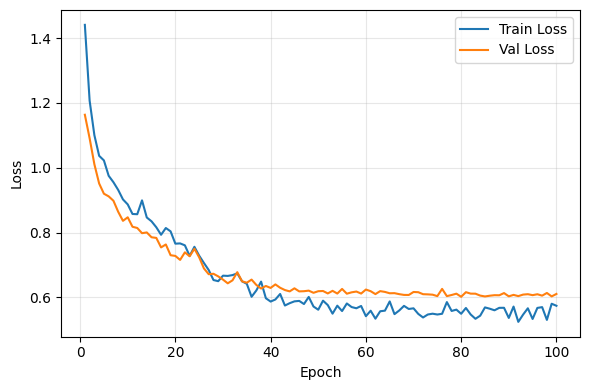

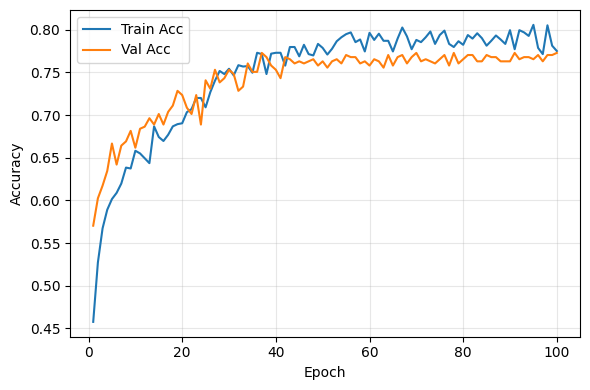

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (1) No-pretrained model + 1DCNN Classifier
mode = "mel"
model_type = "cnn"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=100,
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

**(2) Training [Mel Spectrogram] + [CRNN Classifier]**


=== Training GTsinger (mel, crnn) on cuda ===

Mode = mel → MERT not loaded.

Creating datasets...
[Dataset] Split 'train': 1925 samples
[Dataset] Split 'val': 405 samples

Input feature dim (F): 128
Num classes: 6

Initializing CRNN model...
Model parameters: 743,302

Start training for 100 epochs...

Epoch 1/100


Train Loss: 1.3860, Train Acc: 0.4571
Val   Loss: 1.1799, Val   Acc: 0.5407
✓ New best model saved (val_loss=1.1799)

Epoch 2/100


Train Loss: 1.1165, Train Acc: 0.5652
Val   Loss: 1.5074, Val   Acc: 0.4716

Epoch 3/100


Train Loss: 1.0158, Train Acc: 0.5938
Val   Loss: 0.9350, Val   Acc: 0.6296
✓ New best model saved (val_loss=0.9350)

Epoch 4/100


Train Loss: 0.9330, Train Acc: 0.6197
Val   Loss: 0.9489, Val   Acc: 0.6296

Epoch 5/100


Train Loss: 0.8746, Train Acc: 0.6587
Val   Loss: 0.8706, Val   Acc: 0.6716
✓ New best model saved (val_loss=0.8706)

Epoch 6/100


Train Loss: 0.8057, Train Acc: 0.6857
Val   Loss: 0.9085, Val   Acc: 0.6321

Epoch 7/100


Train Loss: 0.7887, Train Acc: 0.6909
Val   Loss: 0.8173, Val   Acc: 0.6667
✓ New best model saved (val_loss=0.8173)

Epoch 8/100


Train Loss: 0.7170, Train Acc: 0.7138
Val   Loss: 0.7688, Val   Acc: 0.6938
✓ New best model saved (val_loss=0.7688)

Epoch 9/100


Train Loss: 0.7418, Train Acc: 0.6966
Val   Loss: 0.7803, Val   Acc: 0.7086

Epoch 10/100


Train Loss: 0.6404, Train Acc: 0.7439
Val   Loss: 0.7089, Val   Acc: 0.7136
✓ New best model saved (val_loss=0.7089)

Epoch 11/100


Train Loss: 0.6183, Train Acc: 0.7423
Val   Loss: 0.7067, Val   Acc: 0.7259
✓ New best model saved (val_loss=0.7067)

Epoch 12/100


Train Loss: 0.5963, Train Acc: 0.7636
Val   Loss: 0.7381, Val   Acc: 0.7185

Epoch 13/100


Train Loss: 0.5506, Train Acc: 0.7808
Val   Loss: 0.9020, Val   Acc: 0.6864

Epoch 14/100


Train Loss: 0.5659, Train Acc: 0.7751
Val   Loss: 0.6365, Val   Acc: 0.7506
✓ New best model saved (val_loss=0.6365)

Epoch 15/100


Train Loss: 0.5426, Train Acc: 0.7974
Val   Loss: 0.6268, Val   Acc: 0.7383
✓ New best model saved (val_loss=0.6268)

Epoch 16/100


Train Loss: 0.4710, Train Acc: 0.8244
Val   Loss: 0.8060, Val   Acc: 0.7160

Epoch 17/100


Train Loss: 0.5322, Train Acc: 0.7917
Val   Loss: 0.7005, Val   Acc: 0.7284

Epoch 18/100


Train Loss: 0.4881, Train Acc: 0.8166
Val   Loss: 0.6779, Val   Acc: 0.7506

Epoch 19/100


Train Loss: 0.4412, Train Acc: 0.8306
Val   Loss: 0.5855, Val   Acc: 0.7778
✓ New best model saved (val_loss=0.5855)

Epoch 20/100


Train Loss: 0.3658, Train Acc: 0.8540
Val   Loss: 0.6569, Val   Acc: 0.7679

Epoch 21/100


Train Loss: 0.3829, Train Acc: 0.8603
Val   Loss: 0.7177, Val   Acc: 0.7136

Epoch 22/100


Train Loss: 0.4074, Train Acc: 0.8478
Val   Loss: 0.6827, Val   Acc: 0.7531

Epoch 23/100


Train Loss: 0.4026, Train Acc: 0.8514
Val   Loss: 0.5726, Val   Acc: 0.7728
✓ New best model saved (val_loss=0.5726)

Epoch 24/100


Train Loss: 0.3315, Train Acc: 0.8738
Val   Loss: 0.6305, Val   Acc: 0.7654

Epoch 25/100


Train Loss: 0.3676, Train Acc: 0.8706
Val   Loss: 0.5837, Val   Acc: 0.8025

Epoch 26/100


Train Loss: 0.2951, Train Acc: 0.8945
Val   Loss: 0.6253, Val   Acc: 0.7679

Epoch 27/100


Train Loss: 0.2859, Train Acc: 0.8878
Val   Loss: 0.6545, Val   Acc: 0.7654

Epoch 28/100


Train Loss: 0.2703, Train Acc: 0.9018
Val   Loss: 0.8648, Val   Acc: 0.7235

Epoch 29/100


Train Loss: 0.4136, Train Acc: 0.8436
Val   Loss: 0.6536, Val   Acc: 0.7654

Epoch 30/100


Train Loss: 0.2688, Train Acc: 0.9003
Val   Loss: 0.6165, Val   Acc: 0.7778

Epoch 31/100


Train Loss: 0.2346, Train Acc: 0.9164
Val   Loss: 0.6498, Val   Acc: 0.7901

Epoch 32/100


Train Loss: 0.2170, Train Acc: 0.9325
Val   Loss: 0.6519, Val   Acc: 0.7778

Epoch 33/100


Train Loss: 0.2157, Train Acc: 0.9252
Val   Loss: 0.7180, Val   Acc: 0.7654

Epoch 34/100


Train Loss: 0.1891, Train Acc: 0.9377
Val   Loss: 0.6379, Val   Acc: 0.7901

Epoch 35/100


Train Loss: 0.1527, Train Acc: 0.9543
Val   Loss: 0.6256, Val   Acc: 0.7975

Epoch 36/100


Train Loss: 0.1197, Train Acc: 0.9668
Val   Loss: 0.6315, Val   Acc: 0.7951

Epoch 37/100


Train Loss: 0.1482, Train Acc: 0.9647
Val   Loss: 0.6670, Val   Acc: 0.7802

Epoch 38/100


Train Loss: 0.1220, Train Acc: 0.9662
Val   Loss: 0.6609, Val   Acc: 0.8000

Epoch 39/100


Train Loss: 0.1129, Train Acc: 0.9647
Val   Loss: 0.6953, Val   Acc: 0.7753

Epoch 40/100


Train Loss: 0.0972, Train Acc: 0.9756
Val   Loss: 0.6650, Val   Acc: 0.7926

Epoch 41/100


Train Loss: 0.0885, Train Acc: 0.9777
Val   Loss: 0.6889, Val   Acc: 0.7877

Epoch 42/100


Train Loss: 0.0963, Train Acc: 0.9714
Val   Loss: 0.6581, Val   Acc: 0.7951

Epoch 43/100


Train Loss: 0.0817, Train Acc: 0.9839
Val   Loss: 0.6815, Val   Acc: 0.7951

Epoch 44/100


Train Loss: 0.0834, Train Acc: 0.9782
Val   Loss: 0.6721, Val   Acc: 0.7778

Epoch 45/100


Train Loss: 0.0875, Train Acc: 0.9782
Val   Loss: 0.6956, Val   Acc: 0.8025

Epoch 46/100


Train Loss: 0.0858, Train Acc: 0.9761
Val   Loss: 0.7311, Val   Acc: 0.7728

Epoch 47/100


Train Loss: 0.0807, Train Acc: 0.9803
Val   Loss: 0.6819, Val   Acc: 0.8000

Epoch 48/100


Train Loss: 0.0913, Train Acc: 0.9808
Val   Loss: 0.7104, Val   Acc: 0.7926

Epoch 49/100


Train Loss: 0.0850, Train Acc: 0.9771
Val   Loss: 0.6974, Val   Acc: 0.7975

Epoch 50/100


Train Loss: 0.0790, Train Acc: 0.9766
Val   Loss: 0.7033, Val   Acc: 0.7877

Epoch 51/100


Train Loss: 0.0817, Train Acc: 0.9782
Val   Loss: 0.7172, Val   Acc: 0.7852

Epoch 52/100


Train Loss: 0.0757, Train Acc: 0.9818
Val   Loss: 0.6874, Val   Acc: 0.7901

Epoch 53/100


Train Loss: 0.0729, Train Acc: 0.9855
Val   Loss: 0.7304, Val   Acc: 0.7901

Epoch 54/100


Train Loss: 0.0752, Train Acc: 0.9803
Val   Loss: 0.6986, Val   Acc: 0.7951

Epoch 55/100


Train Loss: 0.0844, Train Acc: 0.9813
Val   Loss: 0.6707, Val   Acc: 0.7975

Epoch 56/100


Train Loss: 0.0806, Train Acc: 0.9782
Val   Loss: 0.6999, Val   Acc: 0.7827

Epoch 57/100


Train Loss: 0.0953, Train Acc: 0.9797
Val   Loss: 0.6707, Val   Acc: 0.7827

Epoch 58/100


Train Loss: 0.0738, Train Acc: 0.9813
Val   Loss: 0.7098, Val   Acc: 0.7852

Epoch 59/100


Train Loss: 0.0739, Train Acc: 0.9839
Val   Loss: 0.6956, Val   Acc: 0.7926

Epoch 60/100


Train Loss: 0.0806, Train Acc: 0.9797
Val   Loss: 0.7200, Val   Acc: 0.7951

Epoch 61/100


Train Loss: 0.0764, Train Acc: 0.9808
Val   Loss: 0.6980, Val   Acc: 0.7901

Epoch 62/100


Train Loss: 0.0709, Train Acc: 0.9834
Val   Loss: 0.6938, Val   Acc: 0.7852

Epoch 63/100


Train Loss: 0.0738, Train Acc: 0.9745
Val   Loss: 0.7071, Val   Acc: 0.7951

Epoch 64/100


Train Loss: 0.0735, Train Acc: 0.9813
Val   Loss: 0.7014, Val   Acc: 0.8000

Epoch 65/100


Train Loss: 0.0900, Train Acc: 0.9756
Val   Loss: 0.7153, Val   Acc: 0.7901

Epoch 66/100


Train Loss: 0.0772, Train Acc: 0.9839
Val   Loss: 0.7039, Val   Acc: 0.7901

Epoch 67/100


Train Loss: 0.0744, Train Acc: 0.9860
Val   Loss: 0.6940, Val   Acc: 0.7926

Epoch 68/100


Train Loss: 0.0775, Train Acc: 0.9766
Val   Loss: 0.7025, Val   Acc: 0.7926

Epoch 69/100


Train Loss: 0.0743, Train Acc: 0.9823
Val   Loss: 0.7175, Val   Acc: 0.7975

Epoch 70/100


Train Loss: 0.1022, Train Acc: 0.9797
Val   Loss: 0.6893, Val   Acc: 0.7926

Epoch 71/100


Train Loss: 0.0792, Train Acc: 0.9808
Val   Loss: 0.7138, Val   Acc: 0.7975

Epoch 72/100


Train Loss: 0.0737, Train Acc: 0.9808
Val   Loss: 0.6913, Val   Acc: 0.8000

Epoch 73/100


Train Loss: 0.0727, Train Acc: 0.9844
Val   Loss: 0.7120, Val   Acc: 0.7951

Epoch 74/100


Train Loss: 0.0676, Train Acc: 0.9839
Val   Loss: 0.7104, Val   Acc: 0.7975

Epoch 75/100


Train Loss: 0.0677, Train Acc: 0.9839
Val   Loss: 0.6924, Val   Acc: 0.7926

Epoch 76/100


Train Loss: 0.0953, Train Acc: 0.9756
Val   Loss: 0.6812, Val   Acc: 0.7901

Epoch 77/100


Train Loss: 0.0759, Train Acc: 0.9839
Val   Loss: 0.7045, Val   Acc: 0.7926

Epoch 78/100


Train Loss: 0.0730, Train Acc: 0.9818
Val   Loss: 0.6966, Val   Acc: 0.7975

Epoch 79/100


Train Loss: 0.0781, Train Acc: 0.9839
Val   Loss: 0.7092, Val   Acc: 0.7951

Epoch 80/100


Train Loss: 0.0690, Train Acc: 0.9855
Val   Loss: 0.6906, Val   Acc: 0.7877

Epoch 81/100


Train Loss: 0.0767, Train Acc: 0.9777
Val   Loss: 0.6811, Val   Acc: 0.7926

Epoch 82/100


Train Loss: 0.0693, Train Acc: 0.9808
Val   Loss: 0.7021, Val   Acc: 0.7951

Epoch 83/100


Train Loss: 0.0787, Train Acc: 0.9777
Val   Loss: 0.6867, Val   Acc: 0.7951

Epoch 84/100


Train Loss: 0.0702, Train Acc: 0.9829
Val   Loss: 0.7115, Val   Acc: 0.7901

Epoch 85/100


Train Loss: 0.0769, Train Acc: 0.9829
Val   Loss: 0.7065, Val   Acc: 0.7926

Epoch 86/100


Train Loss: 0.0850, Train Acc: 0.9797
Val   Loss: 0.6857, Val   Acc: 0.7877

Epoch 87/100


Train Loss: 0.0761, Train Acc: 0.9808
Val   Loss: 0.6999, Val   Acc: 0.7951

Epoch 88/100


Train Loss: 0.0752, Train Acc: 0.9860
Val   Loss: 0.7092, Val   Acc: 0.7926

Epoch 89/100


Train Loss: 0.0853, Train Acc: 0.9766
Val   Loss: 0.7041, Val   Acc: 0.7975

Epoch 90/100


Train Loss: 0.0894, Train Acc: 0.9829
Val   Loss: 0.7004, Val   Acc: 0.7901

Epoch 91/100


Train Loss: 0.0786, Train Acc: 0.9771
Val   Loss: 0.6845, Val   Acc: 0.7951

Epoch 92/100


Train Loss: 0.0702, Train Acc: 0.9839
Val   Loss: 0.6890, Val   Acc: 0.7852

Epoch 93/100


Train Loss: 0.0748, Train Acc: 0.9818
Val   Loss: 0.6892, Val   Acc: 0.7975

Epoch 94/100


Train Loss: 0.0865, Train Acc: 0.9797
Val   Loss: 0.6754, Val   Acc: 0.8049

Epoch 95/100


Train Loss: 0.0734, Train Acc: 0.9771
Val   Loss: 0.6859, Val   Acc: 0.7975

Epoch 96/100


Train Loss: 0.0783, Train Acc: 0.9808
Val   Loss: 0.6975, Val   Acc: 0.7975

Epoch 97/100


Train Loss: 0.0800, Train Acc: 0.9771
Val   Loss: 0.6827, Val   Acc: 0.7926

Epoch 98/100


Train Loss: 0.0786, Train Acc: 0.9792
Val   Loss: 0.6598, Val   Acc: 0.7926

Epoch 99/100


Train Loss: 0.0909, Train Acc: 0.9751
Val   Loss: 0.6840, Val   Acc: 0.8000

Epoch 100/100


Train Loss: 0.0703, Train Acc: 0.9849
Val   Loss: 0.7095, Val   Acc: 0.7926

=== Training finished ===
Best val loss: 0.5726
Best model path: /home/steve/final_report/train/GT_results/mel_crnn/best_model.pth


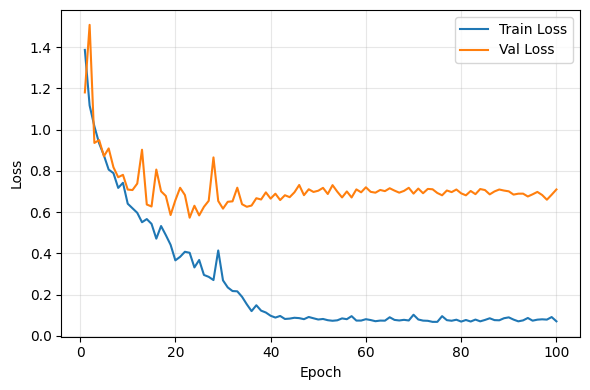

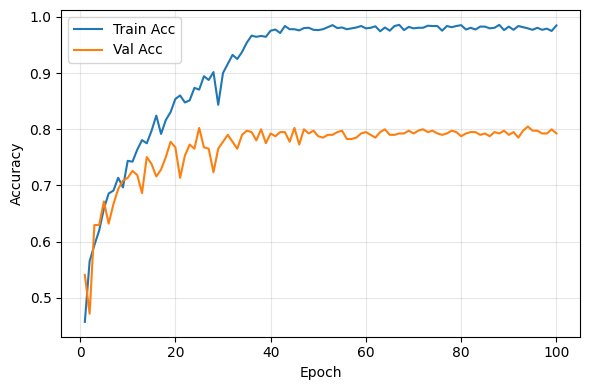

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (2) No-pretrained model + CRNN Classifier
mode = "mel"
model_type = "crnn"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=100,
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

**(3) Training [Mel Spectrogram] + [Transformer Classifier]**


=== Training GTsinger (mel, transformer) on cuda ===

Mode = mel → MERT not loaded.

Creating datasets...
[Dataset] Split 'train': 1930 samples
[Dataset] Split 'val': 412 samples

Input feature dim (F): 128
Num classes: 6

Initializing TRANSFORMER model...
Model parameters: 149,766

Results dir: /home/steve/final_report/train/GT_results/mel_transformer

Start training for 100 epochs...

Epoch 1/100


Train Loss: 1.3751, Train Acc: 0.4560
Val   Loss: 1.1690, Val   Acc: 0.5510
✓ New best model saved (val_loss=1.1690)

Epoch 2/100


Train Loss: 1.1205, Train Acc: 0.5627
Val   Loss: 1.0550, Val   Acc: 0.5995
✓ New best model saved (val_loss=1.0550)

Epoch 3/100


Train Loss: 1.0027, Train Acc: 0.6036
Val   Loss: 0.9678, Val   Acc: 0.6092
✓ New best model saved (val_loss=0.9678)

Epoch 4/100


Train Loss: 0.9529, Train Acc: 0.6197
Val   Loss: 0.9534, Val   Acc: 0.6481
✓ New best model saved (val_loss=0.9534)

Epoch 5/100


Train Loss: 0.9091, Train Acc: 0.6394
Val   Loss: 0.9052, Val   Acc: 0.6505
✓ New best model saved (val_loss=0.9052)

Epoch 6/100


Train Loss: 0.8119, Train Acc: 0.6762
Val   Loss: 0.8457, Val   Acc: 0.6650
✓ New best model saved (val_loss=0.8457)

Epoch 7/100


Train Loss: 0.7957, Train Acc: 0.6870
Val   Loss: 0.8881, Val   Acc: 0.6408

Epoch 8/100


Train Loss: 0.7243, Train Acc: 0.7166
Val   Loss: 0.8386, Val   Acc: 0.6699
✓ New best model saved (val_loss=0.8386)

Epoch 9/100


Train Loss: 0.6667, Train Acc: 0.7280
Val   Loss: 0.7857, Val   Acc: 0.7184
✓ New best model saved (val_loss=0.7857)

Epoch 10/100


Train Loss: 0.6373, Train Acc: 0.7373
Val   Loss: 0.7352, Val   Acc: 0.7403
✓ New best model saved (val_loss=0.7352)

Epoch 11/100


Train Loss: 0.6186, Train Acc: 0.7596
Val   Loss: 0.7759, Val   Acc: 0.7160

Epoch 12/100


Train Loss: 0.5503, Train Acc: 0.7933
Val   Loss: 0.8068, Val   Acc: 0.6893

Epoch 13/100


Train Loss: 0.5317, Train Acc: 0.7969
Val   Loss: 0.7429, Val   Acc: 0.7306

Epoch 14/100


Train Loss: 0.5159, Train Acc: 0.7984
Val   Loss: 0.7378, Val   Acc: 0.7209

Epoch 15/100


Train Loss: 0.3846, Train Acc: 0.8627
Val   Loss: 0.7906, Val   Acc: 0.7209

Epoch 16/100


Train Loss: 0.3750, Train Acc: 0.8591
Val   Loss: 0.7687, Val   Acc: 0.7282

Epoch 17/100


Train Loss: 0.3187, Train Acc: 0.8793
Val   Loss: 0.8372, Val   Acc: 0.7306

Epoch 18/100


Train Loss: 0.3030, Train Acc: 0.8927
Val   Loss: 0.7804, Val   Acc: 0.7403

Epoch 19/100


Train Loss: 0.2715, Train Acc: 0.9021
Val   Loss: 0.7655, Val   Acc: 0.7621

Epoch 20/100


Train Loss: 0.2384, Train Acc: 0.9244
Val   Loss: 0.7712, Val   Acc: 0.7403

Epoch 21/100


Train Loss: 0.2216, Train Acc: 0.9358
Val   Loss: 0.7498, Val   Acc: 0.7621

Epoch 22/100


Train Loss: 0.2136, Train Acc: 0.9326
Val   Loss: 0.7934, Val   Acc: 0.7451

Epoch 23/100


Train Loss: 0.1973, Train Acc: 0.9425
Val   Loss: 0.7847, Val   Acc: 0.7743

Epoch 24/100


Train Loss: 0.1818, Train Acc: 0.9472
Val   Loss: 0.7669, Val   Acc: 0.7791

Epoch 25/100


Train Loss: 0.1834, Train Acc: 0.9451
Val   Loss: 0.7799, Val   Acc: 0.7767

Epoch 26/100


Train Loss: 0.1743, Train Acc: 0.9497
Val   Loss: 0.8064, Val   Acc: 0.7791

Epoch 27/100


Train Loss: 0.1697, Train Acc: 0.9585
Val   Loss: 0.7958, Val   Acc: 0.7743

Epoch 28/100


Train Loss: 0.1631, Train Acc: 0.9622
Val   Loss: 0.7963, Val   Acc: 0.7840

Epoch 29/100


Train Loss: 0.1553, Train Acc: 0.9585
Val   Loss: 0.8133, Val   Acc: 0.7670

Epoch 30/100


Train Loss: 0.1565, Train Acc: 0.9611
Val   Loss: 0.8090, Val   Acc: 0.7791

Epoch 31/100


Train Loss: 0.1511, Train Acc: 0.9575
Val   Loss: 0.8133, Val   Acc: 0.7743

Epoch 32/100


Train Loss: 0.1496, Train Acc: 0.9611
Val   Loss: 0.8183, Val   Acc: 0.7767

Epoch 33/100


Train Loss: 0.1482, Train Acc: 0.9632
Val   Loss: 0.8121, Val   Acc: 0.7743

Epoch 34/100


Train Loss: 0.1446, Train Acc: 0.9642
Val   Loss: 0.8173, Val   Acc: 0.7791

Epoch 35/100


Train Loss: 0.1454, Train Acc: 0.9653
Val   Loss: 0.8184, Val   Acc: 0.7767

Epoch 36/100


Train Loss: 0.1416, Train Acc: 0.9632
Val   Loss: 0.8232, Val   Acc: 0.7840

Epoch 37/100


Train Loss: 0.1436, Train Acc: 0.9596
Val   Loss: 0.8249, Val   Acc: 0.7718

Epoch 38/100


Train Loss: 0.1430, Train Acc: 0.9663
Val   Loss: 0.8276, Val   Acc: 0.7743

Epoch 39/100


Train Loss: 0.1418, Train Acc: 0.9658
Val   Loss: 0.8253, Val   Acc: 0.7743

Epoch 40/100


Train Loss: 0.1399, Train Acc: 0.9663
Val   Loss: 0.8238, Val   Acc: 0.7816

Epoch 41/100


Train Loss: 0.1392, Train Acc: 0.9689
Val   Loss: 0.8273, Val   Acc: 0.7743

Epoch 42/100


Train Loss: 0.1386, Train Acc: 0.9642
Val   Loss: 0.8284, Val   Acc: 0.7743

Epoch 43/100


Train Loss: 0.1387, Train Acc: 0.9648
Val   Loss: 0.8293, Val   Acc: 0.7718

Epoch 44/100


Train Loss: 0.1387, Train Acc: 0.9663
Val   Loss: 0.8303, Val   Acc: 0.7694

Epoch 45/100


Train Loss: 0.1420, Train Acc: 0.9648
Val   Loss: 0.8300, Val   Acc: 0.7718

Epoch 46/100


Train Loss: 0.1364, Train Acc: 0.9684
Val   Loss: 0.8317, Val   Acc: 0.7718

Epoch 47/100


Train Loss: 0.1376, Train Acc: 0.9663
Val   Loss: 0.8322, Val   Acc: 0.7718

Epoch 48/100


Train Loss: 0.1369, Train Acc: 0.9694
Val   Loss: 0.8316, Val   Acc: 0.7718

Epoch 49/100


Train Loss: 0.1337, Train Acc: 0.9668
Val   Loss: 0.8320, Val   Acc: 0.7718

Epoch 50/100


Train Loss: 0.1395, Train Acc: 0.9710
Val   Loss: 0.8328, Val   Acc: 0.7743

Epoch 51/100


Train Loss: 0.1358, Train Acc: 0.9679
Val   Loss: 0.8328, Val   Acc: 0.7743

Epoch 52/100


Train Loss: 0.1354, Train Acc: 0.9663
Val   Loss: 0.8326, Val   Acc: 0.7718

Epoch 53/100


Train Loss: 0.1341, Train Acc: 0.9710
Val   Loss: 0.8324, Val   Acc: 0.7718

Epoch 54/100


Train Loss: 0.1340, Train Acc: 0.9705
Val   Loss: 0.8326, Val   Acc: 0.7718

Epoch 55/100


Train Loss: 0.1375, Train Acc: 0.9689
Val   Loss: 0.8325, Val   Acc: 0.7718

Epoch 56/100


Train Loss: 0.1366, Train Acc: 0.9694
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 57/100


Train Loss: 0.1337, Train Acc: 0.9705
Val   Loss: 0.8326, Val   Acc: 0.7718

Epoch 58/100


Train Loss: 0.1331, Train Acc: 0.9699
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 59/100


Train Loss: 0.1384, Train Acc: 0.9694
Val   Loss: 0.8326, Val   Acc: 0.7718

Epoch 60/100


Train Loss: 0.1349, Train Acc: 0.9725
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 61/100


Train Loss: 0.1367, Train Acc: 0.9684
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 62/100


Train Loss: 0.1389, Train Acc: 0.9668
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 63/100


Train Loss: 0.1397, Train Acc: 0.9653
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 64/100


Train Loss: 0.1345, Train Acc: 0.9731
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 65/100


Train Loss: 0.1379, Train Acc: 0.9694
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 66/100


Train Loss: 0.1336, Train Acc: 0.9674
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 67/100


Train Loss: 0.1367, Train Acc: 0.9699
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 68/100


Train Loss: 0.1359, Train Acc: 0.9694
Val   Loss: 0.8327, Val   Acc: 0.7718

Epoch 69/100


Train Loss: 0.1359, Train Acc: 0.9674
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 70/100


Train Loss: 0.1357, Train Acc: 0.9679
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 71/100


Train Loss: 0.1387, Train Acc: 0.9694
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 72/100


Train Loss: 0.1357, Train Acc: 0.9699
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 73/100


Train Loss: 0.1351, Train Acc: 0.9715
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 74/100


Train Loss: 0.1413, Train Acc: 0.9684
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 75/100


Train Loss: 0.1358, Train Acc: 0.9684
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 76/100


Train Loss: 0.1311, Train Acc: 0.9705
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 77/100


Train Loss: 0.1357, Train Acc: 0.9668
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 78/100


Train Loss: 0.1349, Train Acc: 0.9705
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 79/100


Train Loss: 0.1362, Train Acc: 0.9694
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 80/100


Train Loss: 0.1345, Train Acc: 0.9705
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 81/100


Train Loss: 0.1354, Train Acc: 0.9699
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 82/100


Train Loss: 0.1400, Train Acc: 0.9637
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 83/100


Train Loss: 0.1376, Train Acc: 0.9674
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 84/100


Train Loss: 0.1378, Train Acc: 0.9679
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 85/100


Train Loss: 0.1351, Train Acc: 0.9632
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 86/100


Train Loss: 0.1373, Train Acc: 0.9684
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 87/100


Train Loss: 0.1358, Train Acc: 0.9668
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 88/100


Train Loss: 0.1345, Train Acc: 0.9710
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 89/100


Train Loss: 0.1367, Train Acc: 0.9694
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 90/100


Train Loss: 0.1358, Train Acc: 0.9736
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 91/100


Train Loss: 0.1337, Train Acc: 0.9715
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 92/100


Train Loss: 0.1439, Train Acc: 0.9658
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 93/100


Train Loss: 0.1370, Train Acc: 0.9705
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 94/100


Train Loss: 0.1372, Train Acc: 0.9689
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 95/100


Train Loss: 0.1387, Train Acc: 0.9674
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 96/100


Train Loss: 0.1341, Train Acc: 0.9705
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 97/100


Train Loss: 0.1340, Train Acc: 0.9694
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 98/100


Train Loss: 0.1360, Train Acc: 0.9658
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 99/100


Train Loss: 0.1421, Train Acc: 0.9658
Val   Loss: 0.8328, Val   Acc: 0.7718

Epoch 100/100


Train Loss: 0.1351, Train Acc: 0.9674
Val   Loss: 0.8328, Val   Acc: 0.7718

=== Training finished ===
Best val loss: 0.7352
Best model path: /home/steve/final_report/train/GT_results/mel_transformer/best_model.pth


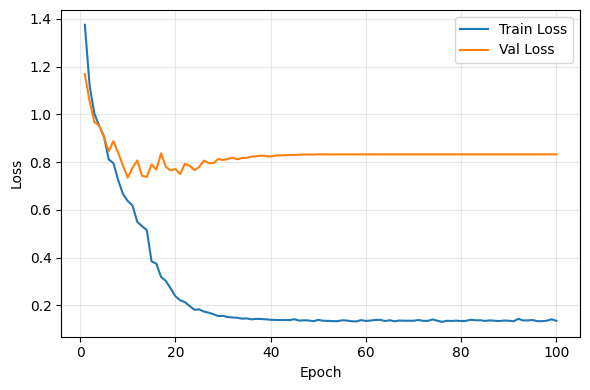

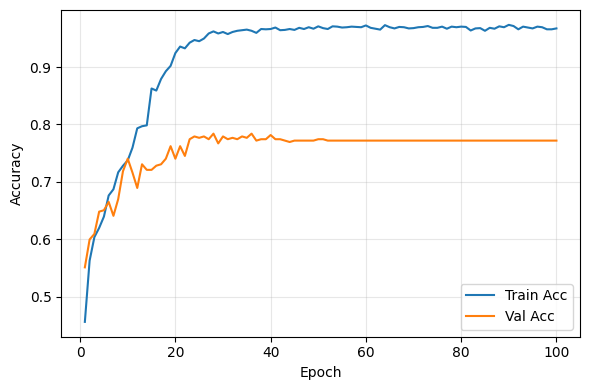

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (3) No-pretrained model + Transformer Classifier
mode = "mel"
model_type = "transformer"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=100,
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

**(4) Training [MERT Pre-trained Model] + [1DCNN Classifier]**


=== Training GTsinger (mert, cnn) on cuda ===

Loading MERT model...

Creating datasets...
[Dataset] Split 'train': 1925 samples
[Dataset] Split 'val': 405 samples

Input feature dim (F): 1024
Num classes: 6

Initializing CNN model...
Model parameters: 664,390

Start training for 50 epochs...

Epoch 1/50


Train Loss: 1.4051, Train Acc: 0.4603
Val   Loss: 1.1098, Val   Acc: 0.5728
✓ New best model saved (val_loss=1.1098)

Epoch 2/50


Train Loss: 1.0134, Train Acc: 0.6223
Val   Loss: 0.8714, Val   Acc: 0.6568
✓ New best model saved (val_loss=0.8714)

Epoch 3/50


Train Loss: 0.8289, Train Acc: 0.6784
Val   Loss: 0.8233, Val   Acc: 0.6840
✓ New best model saved (val_loss=0.8233)

Epoch 4/50


Train Loss: 0.7322, Train Acc: 0.7195
Val   Loss: 0.6611, Val   Acc: 0.7506
✓ New best model saved (val_loss=0.6611)

Epoch 5/50


Train Loss: 0.6623, Train Acc: 0.7481
Val   Loss: 0.7376, Val   Acc: 0.7333

Epoch 6/50


Train Loss: 0.6272, Train Acc: 0.7449
Val   Loss: 0.6038, Val   Acc: 0.7630
✓ New best model saved (val_loss=0.6038)

Epoch 7/50


Train Loss: 0.5775, Train Acc: 0.7782
Val   Loss: 0.5754, Val   Acc: 0.7901
✓ New best model saved (val_loss=0.5754)

Epoch 8/50


Train Loss: 0.4968, Train Acc: 0.8119
Val   Loss: 0.5414, Val   Acc: 0.7802
✓ New best model saved (val_loss=0.5414)

Epoch 9/50


Train Loss: 0.4963, Train Acc: 0.8078
Val   Loss: 0.5403, Val   Acc: 0.8000
✓ New best model saved (val_loss=0.5403)

Epoch 10/50


Train Loss: 0.4435, Train Acc: 0.8306
Val   Loss: 0.5249, Val   Acc: 0.8173
✓ New best model saved (val_loss=0.5249)

Epoch 11/50


Train Loss: 0.4371, Train Acc: 0.8405
Val   Loss: 0.5245, Val   Acc: 0.8321
✓ New best model saved (val_loss=0.5245)

Epoch 12/50


Train Loss: 0.4230, Train Acc: 0.8462
Val   Loss: 0.5076, Val   Acc: 0.7975
✓ New best model saved (val_loss=0.5076)

Epoch 13/50


Train Loss: 0.4444, Train Acc: 0.8374
Val   Loss: 0.4827, Val   Acc: 0.8247
✓ New best model saved (val_loss=0.4827)

Epoch 14/50


Train Loss: 0.3899, Train Acc: 0.8608
Val   Loss: 0.4878, Val   Acc: 0.8198

Epoch 15/50


Train Loss: 0.3893, Train Acc: 0.8478
Val   Loss: 0.4769, Val   Acc: 0.8370
✓ New best model saved (val_loss=0.4769)

Epoch 16/50


Train Loss: 0.3827, Train Acc: 0.8618
Val   Loss: 0.4487, Val   Acc: 0.8198
✓ New best model saved (val_loss=0.4487)

Epoch 17/50


Train Loss: 0.3354, Train Acc: 0.8738
Val   Loss: 0.3947, Val   Acc: 0.8593
✓ New best model saved (val_loss=0.3947)

Epoch 18/50


Train Loss: 0.3429, Train Acc: 0.8722
Val   Loss: 0.5002, Val   Acc: 0.8247

Epoch 19/50


Train Loss: 0.3243, Train Acc: 0.8784
Val   Loss: 0.4430, Val   Acc: 0.8420

Epoch 20/50


Train Loss: 0.3493, Train Acc: 0.8764
Val   Loss: 0.4562, Val   Acc: 0.8123

Epoch 21/50


Train Loss: 0.3050, Train Acc: 0.8894
Val   Loss: 0.4322, Val   Acc: 0.8370

Epoch 22/50


Train Loss: 0.2488, Train Acc: 0.9143
Val   Loss: 0.4009, Val   Acc: 0.8494

Epoch 23/50


Train Loss: 0.2294, Train Acc: 0.9221
Val   Loss: 0.4254, Val   Acc: 0.8370

Epoch 24/50


Train Loss: 0.2280, Train Acc: 0.9325
Val   Loss: 0.4170, Val   Acc: 0.8519

Epoch 25/50


Train Loss: 0.2270, Train Acc: 0.9179
Val   Loss: 0.3915, Val   Acc: 0.8494
✓ New best model saved (val_loss=0.3915)

Epoch 26/50


Train Loss: 0.2223, Train Acc: 0.9283
Val   Loss: 0.4268, Val   Acc: 0.8321

Epoch 27/50


Train Loss: 0.2264, Train Acc: 0.9221
Val   Loss: 0.3802, Val   Acc: 0.8519
✓ New best model saved (val_loss=0.3802)

Epoch 28/50


Train Loss: 0.1990, Train Acc: 0.9278
Val   Loss: 0.3869, Val   Acc: 0.8543

Epoch 29/50


Train Loss: 0.1732, Train Acc: 0.9449
Val   Loss: 0.3902, Val   Acc: 0.8519

Epoch 30/50


Train Loss: 0.1952, Train Acc: 0.9403
Val   Loss: 0.3926, Val   Acc: 0.8469

Epoch 31/50


Train Loss: 0.1931, Train Acc: 0.9319
Val   Loss: 0.4058, Val   Acc: 0.8593

Epoch 32/50


Train Loss: 0.1800, Train Acc: 0.9413
Val   Loss: 0.3920, Val   Acc: 0.8494

Epoch 33/50


Train Loss: 0.1576, Train Acc: 0.9491
Val   Loss: 0.3879, Val   Acc: 0.8519

Epoch 34/50


Train Loss: 0.1358, Train Acc: 0.9590
Val   Loss: 0.4107, Val   Acc: 0.8494

Epoch 35/50


Train Loss: 0.1307, Train Acc: 0.9631
Val   Loss: 0.4068, Val   Acc: 0.8617

Epoch 36/50


Train Loss: 0.1440, Train Acc: 0.9522
Val   Loss: 0.3857, Val   Acc: 0.8444

Epoch 37/50


Train Loss: 0.1375, Train Acc: 0.9548
Val   Loss: 0.3890, Val   Acc: 0.8519

Epoch 38/50


Train Loss: 0.1533, Train Acc: 0.9553
Val   Loss: 0.3937, Val   Acc: 0.8444

Epoch 39/50


Train Loss: 0.1229, Train Acc: 0.9631
Val   Loss: 0.4139, Val   Acc: 0.8519

Epoch 40/50


Train Loss: 0.1427, Train Acc: 0.9584
Val   Loss: 0.3918, Val   Acc: 0.8444

Epoch 41/50


Train Loss: 0.1256, Train Acc: 0.9579
Val   Loss: 0.3889, Val   Acc: 0.8469

Epoch 42/50


Train Loss: 0.1176, Train Acc: 0.9652
Val   Loss: 0.3804, Val   Acc: 0.8469

Epoch 43/50


Train Loss: 0.1320, Train Acc: 0.9517
Val   Loss: 0.3855, Val   Acc: 0.8494

Epoch 44/50


Train Loss: 0.1175, Train Acc: 0.9642
Val   Loss: 0.3854, Val   Acc: 0.8543

Epoch 45/50


Train Loss: 0.1477, Train Acc: 0.9590
Val   Loss: 0.3881, Val   Acc: 0.8543

Epoch 46/50


Train Loss: 0.1131, Train Acc: 0.9688
Val   Loss: 0.3967, Val   Acc: 0.8494

Epoch 47/50


Train Loss: 0.1107, Train Acc: 0.9673
Val   Loss: 0.3823, Val   Acc: 0.8593

Epoch 48/50


Train Loss: 0.1303, Train Acc: 0.9553
Val   Loss: 0.3801, Val   Acc: 0.8444
✓ New best model saved (val_loss=0.3801)

Epoch 49/50


Train Loss: 0.1130, Train Acc: 0.9657
Val   Loss: 0.3843, Val   Acc: 0.8519

Epoch 50/50


Train Loss: 0.1121, Train Acc: 0.9662
Val   Loss: 0.3964, Val   Acc: 0.8519

=== Training finished ===
Best val loss: 0.3801
Best model path: /home/steve/final_report/train/GT_results/mert_cnn/best_model.pth


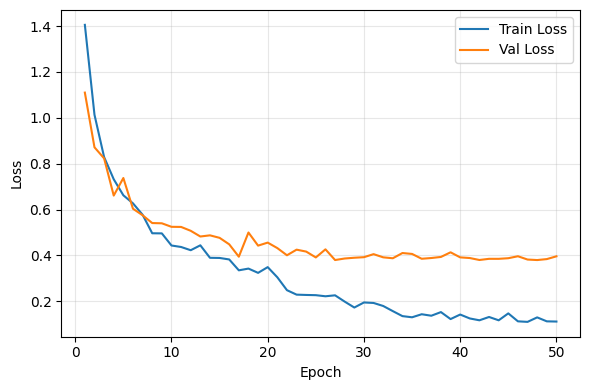

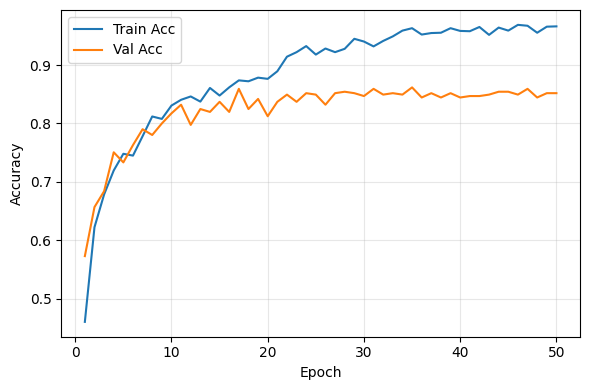

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (4) Pretrained model (MERT) + 1DCNN Classifier
mode = "mert"
model_type = "cnn"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=50, # 50 epochs due to the fast convergence
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

**(5) Training [MERT Pre-trained Model] + [CRNN Classifier]**


=== Training GTsinger (mert, crnn) on cuda ===

Loading MERT model...

Creating datasets...
[Dataset] Split 'train': 1925 samples
[Dataset] Split 'val': 405 samples

Input feature dim (F): 1024
Num classes: 6

Initializing CRNN model...
Model parameters: 1,316,742

Start training for 50 epochs...

Epoch 1/50


Train Loss: 1.2794, Train Acc: 0.4930
Val   Loss: 1.0148, Val   Acc: 0.5926
✓ New best model saved (val_loss=1.0148)

Epoch 2/50


Train Loss: 0.9073, Train Acc: 0.6499
Val   Loss: 0.8656, Val   Acc: 0.6593
✓ New best model saved (val_loss=0.8656)

Epoch 3/50


Train Loss: 0.7245, Train Acc: 0.7158
Val   Loss: 0.7562, Val   Acc: 0.6988
✓ New best model saved (val_loss=0.7562)

Epoch 4/50


Train Loss: 0.6884, Train Acc: 0.7356
Val   Loss: 0.6256, Val   Acc: 0.7654
✓ New best model saved (val_loss=0.6256)

Epoch 5/50


Train Loss: 0.5626, Train Acc: 0.7777
Val   Loss: 0.6234, Val   Acc: 0.7679
✓ New best model saved (val_loss=0.6234)

Epoch 6/50


Train Loss: 0.4641, Train Acc: 0.8301
Val   Loss: 0.6192, Val   Acc: 0.7556
✓ New best model saved (val_loss=0.6192)

Epoch 7/50


Train Loss: 0.4861, Train Acc: 0.8094
Val   Loss: 0.5918, Val   Acc: 0.7877
✓ New best model saved (val_loss=0.5918)

Epoch 8/50


Train Loss: 0.3510, Train Acc: 0.8748
Val   Loss: 0.5614, Val   Acc: 0.7951
✓ New best model saved (val_loss=0.5614)

Epoch 9/50


Train Loss: 0.3674, Train Acc: 0.8618
Val   Loss: 0.5924, Val   Acc: 0.7654

Epoch 10/50


Train Loss: 0.2951, Train Acc: 0.8925
Val   Loss: 0.5215, Val   Acc: 0.8123
✓ New best model saved (val_loss=0.5215)

Epoch 11/50


Train Loss: 0.2423, Train Acc: 0.9127
Val   Loss: 0.4916, Val   Acc: 0.8272
✓ New best model saved (val_loss=0.4916)

Epoch 12/50


Train Loss: 0.2698, Train Acc: 0.9013
Val   Loss: 0.4692, Val   Acc: 0.8469
✓ New best model saved (val_loss=0.4692)

Epoch 13/50


Train Loss: 0.2347, Train Acc: 0.9148
Val   Loss: 0.5337, Val   Acc: 0.8148

Epoch 14/50


Train Loss: 0.1703, Train Acc: 0.9392
Val   Loss: 0.5804, Val   Acc: 0.8099

Epoch 15/50


Train Loss: 0.1590, Train Acc: 0.9455
Val   Loss: 0.6239, Val   Acc: 0.7827

Epoch 16/50


Train Loss: 0.2125, Train Acc: 0.9184
Val   Loss: 0.5645, Val   Acc: 0.8247

Epoch 17/50


Train Loss: 0.0929, Train Acc: 0.9704
Val   Loss: 0.4885, Val   Acc: 0.8494

Epoch 18/50


Train Loss: 0.0650, Train Acc: 0.9808
Val   Loss: 0.4635, Val   Acc: 0.8494
✓ New best model saved (val_loss=0.4635)

Epoch 19/50


Train Loss: 0.0544, Train Acc: 0.9849
Val   Loss: 0.5254, Val   Acc: 0.8494

Epoch 20/50


Train Loss: 0.0815, Train Acc: 0.9756
Val   Loss: 0.8308, Val   Acc: 0.8321

Epoch 21/50


Train Loss: 0.1269, Train Acc: 0.9600
Val   Loss: 0.5366, Val   Acc: 0.8469

Epoch 22/50


Train Loss: 0.0583, Train Acc: 0.9839
Val   Loss: 0.4876, Val   Acc: 0.8321

Epoch 23/50


Train Loss: 0.0327, Train Acc: 0.9943
Val   Loss: 0.4833, Val   Acc: 0.8568

Epoch 24/50


Train Loss: 0.0274, Train Acc: 0.9958
Val   Loss: 0.4926, Val   Acc: 0.8667

Epoch 25/50


Train Loss: 0.0315, Train Acc: 0.9912
Val   Loss: 0.8039, Val   Acc: 0.8099

Epoch 26/50


Train Loss: 0.0645, Train Acc: 0.9881
Val   Loss: 0.5879, Val   Acc: 0.8346

Epoch 27/50


Train Loss: 0.0316, Train Acc: 0.9943
Val   Loss: 0.5532, Val   Acc: 0.8543

Epoch 28/50


Train Loss: 0.0179, Train Acc: 0.9964
Val   Loss: 0.5509, Val   Acc: 0.8543

Epoch 29/50


Train Loss: 0.0109, Train Acc: 0.9990
Val   Loss: 0.5541, Val   Acc: 0.8593

Epoch 30/50


Train Loss: 0.0180, Train Acc: 0.9979
Val   Loss: 0.5774, Val   Acc: 0.8568

Epoch 31/50


Train Loss: 0.0142, Train Acc: 0.9984
Val   Loss: 0.5615, Val   Acc: 0.8469

Epoch 32/50


Train Loss: 0.0158, Train Acc: 0.9990
Val   Loss: 0.5672, Val   Acc: 0.8494

Epoch 33/50


Train Loss: 0.0170, Train Acc: 0.9984
Val   Loss: 0.5955, Val   Acc: 0.8568

Epoch 34/50


Train Loss: 0.0115, Train Acc: 0.9984
Val   Loss: 0.5964, Val   Acc: 0.8444

Epoch 35/50


Train Loss: 0.0103, Train Acc: 0.9995
Val   Loss: 0.6069, Val   Acc: 0.8494

Epoch 36/50


Train Loss: 0.0154, Train Acc: 0.9984
Val   Loss: 0.6055, Val   Acc: 0.8519

Epoch 37/50


Train Loss: 0.0119, Train Acc: 0.9974
Val   Loss: 0.6170, Val   Acc: 0.8642

Epoch 38/50


Train Loss: 0.0094, Train Acc: 0.9984
Val   Loss: 0.5757, Val   Acc: 0.8494

Epoch 39/50


Train Loss: 0.0086, Train Acc: 0.9990
Val   Loss: 0.5808, Val   Acc: 0.8494

Epoch 40/50


Train Loss: 0.0090, Train Acc: 0.9990
Val   Loss: 0.5825, Val   Acc: 0.8370

Epoch 41/50


Train Loss: 0.0101, Train Acc: 0.9995
Val   Loss: 0.5822, Val   Acc: 0.8469

Epoch 42/50


Train Loss: 0.0083, Train Acc: 1.0000
Val   Loss: 0.5754, Val   Acc: 0.8519

Epoch 43/50


Train Loss: 0.0118, Train Acc: 0.9979
Val   Loss: 0.6076, Val   Acc: 0.8568

Epoch 44/50


Train Loss: 0.0092, Train Acc: 0.9990
Val   Loss: 0.5944, Val   Acc: 0.8494

Epoch 45/50


Train Loss: 0.0173, Train Acc: 0.9990
Val   Loss: 0.5940, Val   Acc: 0.8593

Epoch 46/50


Train Loss: 0.0075, Train Acc: 0.9990
Val   Loss: 0.5893, Val   Acc: 0.8593

Epoch 47/50


Train Loss: 0.0068, Train Acc: 0.9995
Val   Loss: 0.5823, Val   Acc: 0.8593

Epoch 48/50


Train Loss: 0.0103, Train Acc: 0.9990
Val   Loss: 0.5745, Val   Acc: 0.8469

Epoch 49/50


Train Loss: 0.0085, Train Acc: 0.9995
Val   Loss: 0.5790, Val   Acc: 0.8519

Epoch 50/50


Train Loss: 0.0073, Train Acc: 0.9990
Val   Loss: 0.5703, Val   Acc: 0.8444

=== Training finished ===
Best val loss: 0.4635
Best model path: /home/steve/final_report/train/GT_results/mert_crnn/best_model.pth


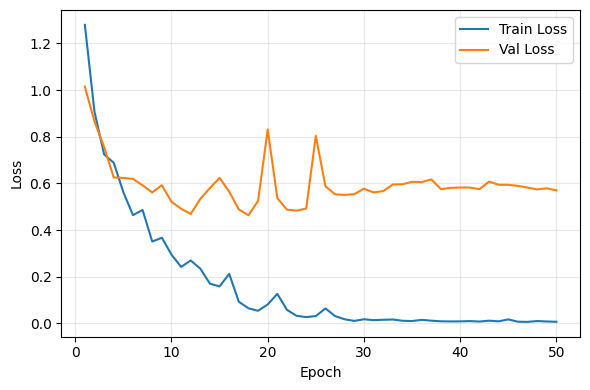

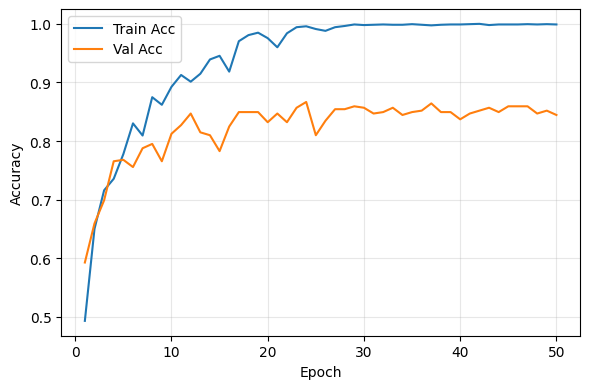

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (5) Pretrained model (MERT) + CRNN Classifier
mode = "mert"
model_type = "crnn"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=50, # 50 epochs due to the fast convergence
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

**(6) Training [MERT Pre-trained Model] + [Transformer Classifier]**


=== Training GTsinger (mert, transformer) on cuda ===

Loading MERT model...

Creating datasets...
[Dataset] Split 'train': 1925 samples
[Dataset] Split 'val': 405 samples

Input feature dim (F): 1024
Num classes: 6

Initializing TRANSFORMER model...
Model parameters: 264,454

Start training for 50 epochs...

Epoch 1/50


Train Loss: 1.4753, Train Acc: 0.4229
Val   Loss: 1.1259, Val   Acc: 0.5259
✓ New best model saved (val_loss=1.1259)

Epoch 2/50


Train Loss: 1.0293, Train Acc: 0.6078
Val   Loss: 1.1282, Val   Acc: 0.5333

Epoch 3/50


Train Loss: 0.8779, Train Acc: 0.6613
Val   Loss: 0.8004, Val   Acc: 0.6815
✓ New best model saved (val_loss=0.8004)

Epoch 4/50


Train Loss: 0.7605, Train Acc: 0.6764
Val   Loss: 0.7859, Val   Acc: 0.7012
✓ New best model saved (val_loss=0.7859)

Epoch 5/50


Train Loss: 0.6611, Train Acc: 0.7382
Val   Loss: 0.7117, Val   Acc: 0.7481
✓ New best model saved (val_loss=0.7117)

Epoch 6/50


Train Loss: 0.5691, Train Acc: 0.7771
Val   Loss: 0.6141, Val   Acc: 0.7481
✓ New best model saved (val_loss=0.6141)

Epoch 7/50


Train Loss: 0.4676, Train Acc: 0.8135
Val   Loss: 0.7089, Val   Acc: 0.7383

Epoch 8/50


Train Loss: 0.4653, Train Acc: 0.8140
Val   Loss: 0.7161, Val   Acc: 0.7333

Epoch 9/50


Train Loss: 0.4242, Train Acc: 0.8296
Val   Loss: 0.6185, Val   Acc: 0.7556

Epoch 10/50


Train Loss: 0.3458, Train Acc: 0.8670
Val   Loss: 0.8197, Val   Acc: 0.7358

Epoch 11/50


Train Loss: 0.2384, Train Acc: 0.9138
Val   Loss: 0.6210, Val   Acc: 0.7852

Epoch 12/50


Train Loss: 0.1850, Train Acc: 0.9429
Val   Loss: 0.6983, Val   Acc: 0.7630

Epoch 13/50


Train Loss: 0.1653, Train Acc: 0.9429
Val   Loss: 0.6789, Val   Acc: 0.7802

Epoch 14/50


Train Loss: 0.1201, Train Acc: 0.9558
Val   Loss: 0.7838, Val   Acc: 0.7778

Epoch 15/50


Train Loss: 0.0939, Train Acc: 0.9694
Val   Loss: 0.7501, Val   Acc: 0.7580

Epoch 16/50


Train Loss: 0.0579, Train Acc: 0.9896
Val   Loss: 0.7621, Val   Acc: 0.7704

Epoch 17/50


Train Loss: 0.0570, Train Acc: 0.9906
Val   Loss: 0.8152, Val   Acc: 0.7679

Epoch 18/50


Train Loss: 0.0597, Train Acc: 0.9844
Val   Loss: 0.9059, Val   Acc: 0.7654

Epoch 19/50


Train Loss: 0.0380, Train Acc: 0.9948
Val   Loss: 0.9008, Val   Acc: 0.7457

Epoch 20/50


Train Loss: 0.0268, Train Acc: 0.9984
Val   Loss: 0.9264, Val   Acc: 0.7531

Epoch 21/50


Train Loss: 0.0242, Train Acc: 0.9984
Val   Loss: 0.9519, Val   Acc: 0.7432

Epoch 22/50


Train Loss: 0.0201, Train Acc: 0.9995
Val   Loss: 0.9531, Val   Acc: 0.7556

Epoch 23/50


Train Loss: 0.0184, Train Acc: 1.0000
Val   Loss: 0.9613, Val   Acc: 0.7556

Epoch 24/50


Train Loss: 0.0175, Train Acc: 0.9995
Val   Loss: 0.9767, Val   Acc: 0.7531

Epoch 25/50


Train Loss: 0.0158, Train Acc: 0.9995
Val   Loss: 0.9933, Val   Acc: 0.7481

Epoch 26/50


Train Loss: 0.0151, Train Acc: 1.0000
Val   Loss: 1.0061, Val   Acc: 0.7506

Epoch 27/50


Train Loss: 0.0143, Train Acc: 1.0000
Val   Loss: 0.9997, Val   Acc: 0.7580

Epoch 28/50


Train Loss: 0.0137, Train Acc: 1.0000
Val   Loss: 1.0069, Val   Acc: 0.7481

Epoch 29/50


Train Loss: 0.0131, Train Acc: 1.0000
Val   Loss: 1.0183, Val   Acc: 0.7531

Epoch 30/50


Train Loss: 0.0133, Train Acc: 1.0000
Val   Loss: 1.0171, Val   Acc: 0.7531

Epoch 31/50


Train Loss: 0.0135, Train Acc: 1.0000
Val   Loss: 1.0197, Val   Acc: 0.7531

Epoch 32/50


Train Loss: 0.0125, Train Acc: 1.0000
Val   Loss: 1.0200, Val   Acc: 0.7580

Epoch 33/50


Train Loss: 0.0123, Train Acc: 1.0000
Val   Loss: 1.0254, Val   Acc: 0.7531

Epoch 34/50


Train Loss: 0.0125, Train Acc: 1.0000
Val   Loss: 1.0234, Val   Acc: 0.7630

Epoch 35/50


Train Loss: 0.0119, Train Acc: 1.0000
Val   Loss: 1.0255, Val   Acc: 0.7630

Epoch 36/50


Train Loss: 0.0121, Train Acc: 1.0000
Val   Loss: 1.0287, Val   Acc: 0.7580

Epoch 37/50


Train Loss: 0.0114, Train Acc: 1.0000
Val   Loss: 1.0304, Val   Acc: 0.7605

Epoch 38/50


Train Loss: 0.0121, Train Acc: 1.0000
Val   Loss: 1.0307, Val   Acc: 0.7630

Epoch 39/50


Train Loss: 0.0115, Train Acc: 1.0000
Val   Loss: 1.0312, Val   Acc: 0.7630

Epoch 40/50


Train Loss: 0.0116, Train Acc: 1.0000
Val   Loss: 1.0326, Val   Acc: 0.7630

Epoch 41/50


Train Loss: 0.0113, Train Acc: 1.0000
Val   Loss: 1.0313, Val   Acc: 0.7654

Epoch 42/50


Train Loss: 0.0116, Train Acc: 1.0000
Val   Loss: 1.0331, Val   Acc: 0.7630

Epoch 43/50


Train Loss: 0.0119, Train Acc: 1.0000
Val   Loss: 1.0345, Val   Acc: 0.7630

Epoch 44/50


Train Loss: 0.0116, Train Acc: 1.0000
Val   Loss: 1.0348, Val   Acc: 0.7630

Epoch 45/50


Train Loss: 0.0110, Train Acc: 1.0000
Val   Loss: 1.0356, Val   Acc: 0.7605

Epoch 46/50


Train Loss: 0.0114, Train Acc: 1.0000
Val   Loss: 1.0362, Val   Acc: 0.7605

Epoch 47/50


Train Loss: 0.0116, Train Acc: 1.0000
Val   Loss: 1.0366, Val   Acc: 0.7605

Epoch 48/50


Train Loss: 0.0111, Train Acc: 1.0000
Val   Loss: 1.0370, Val   Acc: 0.7605

Epoch 49/50


Train Loss: 0.0116, Train Acc: 1.0000
Val   Loss: 1.0371, Val   Acc: 0.7630

Epoch 50/50


Train Loss: 0.0111, Train Acc: 1.0000
Val   Loss: 1.0375, Val   Acc: 0.7630

=== Training finished ===
Best val loss: 0.6141
Best model path: /home/steve/final_report/train/GT_results/mert_transformer/best_model.pth


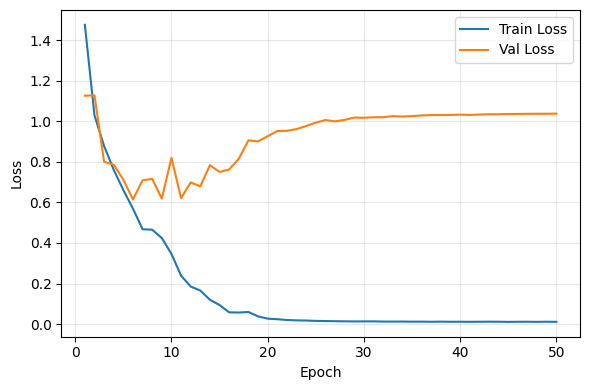

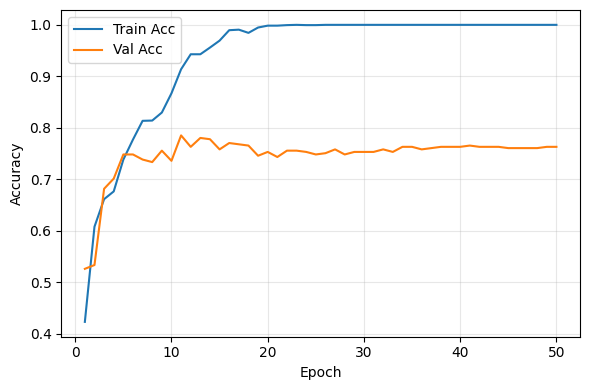

In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"   # root dir

# (6) Pretrained model (MERT) + Transformer Classifier
mode = "mert"
model_type = "transformer"

model, history = train_gtsinger(
    metadata_file=metadata_file,
    data_root=data_root,
    mode=mode,
    model_type=model_type,
    n_mels=128,
    batch_size=32,
    epochs=50, # 50 epochs due to the fast convergence
    lr=1e-3,
    dropout=0.3,
    seed=42,
    results_dir=f"./train/GT_results",
)

### 3-9 Training Results

Overall, using the pre-trained MERT model for transfer learning improved validation accuracy across all claissifers.​ However, more complex classifiers shows larger gaps between training and validation accuracy, indicating there is overfitting and showing lower validation accuracy when using the pre-trained model MERT.​

**Training Curve Comparison**

![Training Curve Comparison](https://raw.githubusercontent.com/stevekslee/MIE1517-2025-Fall---Final-Report-Team20-/main/Training%20curves.png)
*Figure 3. Training Curve Comparison*

Thus, we selected the `[MERT] + [1D-CNN]` pipeline as our final model, since it offered the highest validation accuracy with the best generalization performance”

## 4. Implementation on New Data

This section demonstrates how to use the trained model to make predictions on new, unseen audio files. The process involves loading a trained model checkpoint, preprocessing the new audio file using the same pipeline as training, and generating predictions.

### 4-1. Loading a Trained Model

First, we load the trained model from a saved checkpoint. The model architecture must match the one used during training.

In [ ]:
def load_trained_model(model_path: str, mode: str = "mert", model_type: str = "cnn", device: str = "cuda"):
    """
    Load a trained model from a checkpoint.

    Args:
        model_path: Path to the saved model checkpoint (.pth file)
        mode: Feature extraction mode ("mert" or "mel")
        model_type: Classifier type ("cnn", "crnn", or "transformer")
        device: Device to load the model on

    Returns:
        Loaded model ready for inference
    """
    # Load label mapping
    results_dir = Path(model_path).parent
    with open(results_dir / "label_mapping.json", "r") as f:
        label_mapping = json.load(f)
    id_to_label = {int(k): v for k, v in label_mapping.items()}

    # Initialize model based on mode
    if mode == "mert":
        from transformers import AutoProcessor, AutoModel
        model_name = "m-a-p/MERT-v1-330M"
        mert_processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        mert_model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        mert_model.eval()
        feature_dim = 1024
    else:
        mert_processor = None
        mert_model = None
        feature_dim = 128  # For mel spectrogram

    # Initialize classifier
    if model_type == "cnn":
        classifier = CNN1D_Classifier(in_channels=feature_dim, n_classes=6, dropout=0.3)
    elif model_type == "crnn":
        classifier = CRNN_Classifier(in_channels=feature_dim, n_classes=6, dropout=0.3)
    elif model_type == "transformer":
        classifier = Transformer_Classifier(in_channels=feature_dim, n_classes=6, dropout=0.3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    # Load trained weights
    classifier.load_state_dict(torch.load(model_path, map_location=device))
    classifier = classifier.to(device)
    classifier.eval()

    return classifier, mert_model, mert_processor, id_to_label

### 4-2. Model Test Function

We create a function for testing the trained models with the test dataset.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def model_test(classifier, test_loader, device, id_to_label=None, results_dir: str | Path = "./results_test"):
    """
    Evaluate model on test_loader:
      - Compute accuracy
      - Compute normalized confusion matrix (per-class)
      - Save confusion matrix as PNG and also display it
      - Compute per-class Precision / Recall / F1 and print as a table
    """
    classifier.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            features = batch["features"].to(device)  # [B, T, F]
            labels = batch["label"].to(device)

            logits = classifier(features)           # [B, n_classes]
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = correct / total
    print(f"\nTest accuracy: {acc:.4f}")

    # ----- Confusion Matrix -----
    results_dir = Path(results_dir)
    results_dir.mkdir(parents=True, exist_ok=True)

    # decide class ids & names
    if id_to_label is not None:
        class_ids = sorted(id_to_label.keys())
        class_names = [id_to_label[i] for i in class_ids]
    else:
        class_ids = sorted(set(all_labels) | set(all_preds))
        class_names = [str(i) for i in class_ids]

    # confusion_matrix per true class
    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=class_ids,
        normalize="true",
    )

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Normalized Confusion Matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # annotate each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            plt.text(
                j, i,
                f"{value:.2f}",
                ha="center",
                va="center",
                color="white" if value > 0.5 else "black",
                fontsize=8,
            )

    plt.tight_layout()
    cm_path = results_dir / "confusion_matrix_normalized.png"
    plt.savefig(cm_path, dpi=150)
    plt.show()
    print(f"Saved normalized confusion matrix to: {cm_path}")

    # ----- Precision / Recall / F1 per class -----
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels,
        all_preds,
        labels=class_ids,
        zero_division=0,
    )

    # ===== Per-class Accuracy =====
    class_accuracy = []
    for cid in class_ids:
        cls_mask = np.array(all_labels) == cid
        cls_correct = (np.array(all_preds)[cls_mask] == cid).sum()
        cls_total = cls_mask.sum()
        acc = cls_correct / max(1, cls_total)
        class_accuracy.append(acc)

    # ===== Print Full Metrics Table =====
    print("\n Per-class Evaluation Metrics:")
    header = f"{'Class':<15} {'Support':>7} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-score':>10}"
    print(header)
    print("-" * len(header))

    for cid, p, r, f, s, a in zip(class_ids, precision, recall, f1, support, class_accuracy):
        name = id_to_label[cid] if id_to_label else str(cid)
        print(f"{name:<15} {s:7d} {a:10.3f} {p:10.3f} {r:10.3f} {f:10.3f}")

    # macro-average
    macro_p = precision.mean()
    macro_r = recall.mean()
    macro_f = f1.mean()
    print("-" * len(header))
    print(f"{'Macro-avg':<15} {sum(support):7d} {macro_p:10.3f} {macro_r:10.3f} {macro_f:10.3f}")

    return acc, all_preds, all_labels

### 4-3. Test The Loaded Model with Test Dataset

Load the test dataset using the data loading class as same as in train and vaild dataset. The test dataset is preprocessed in the same way.


Loading MERT model...
[Dataset] Split 'test': 432 samples


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Test accuracy: 0.8843


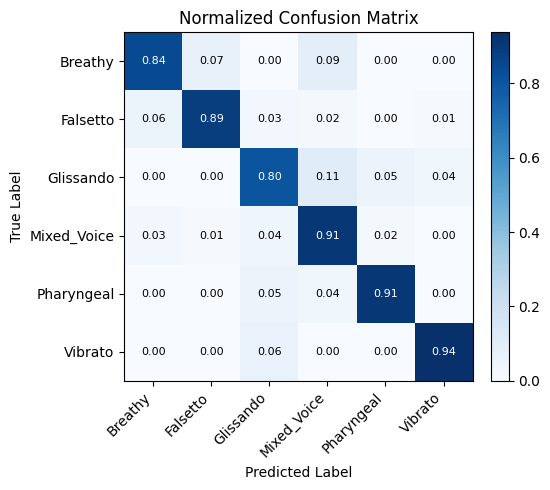

Saved normalized confusion matrix to: test/mert_cnn_test_results/confusion_matrix_normalized.png

 Per-class Evaluation Metrics:
Class           Support   Accuracy  Precision     Recall   F1-score
-------------------------------------------------------------------
Breathy              56      0.839      0.839      0.839      0.839
Falsetto            108      0.889      0.950      0.889      0.919
Glissando            56      0.804      0.776      0.804      0.789
Mixed_Voice         109      0.908      0.868      0.908      0.888
Pharyngeal           55      0.909      0.909      0.909      0.909
Vibrato              48      0.938      0.938      0.938      0.938
-------------------------------------------------------------------
Macro-avg           432      0.880      0.881      0.880


In [ ]:
metadata_file = "./data/GTsinger/English/metadata.json"
data_root = "./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mode = "mert"
model_type = "cnn"     # "cnn" / "crnn" / "transformer"
model_path = f"./train/GT_results/{mode}_{model_type}/best_model.pth"

print("\nLoading MERT model...")
model_name = "m-a-p/MERT-v1-330M"
mert_processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
mert_model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
mert_model.to(device)
mert_model.eval()

test_dataset = GTsingerAudioDataset(
    metadata_file=metadata_file,
    split="test",
    mode=mode,
    mert_processor=mert_processor,
    mert_model=mert_model,
    n_mels=128,
    max_length_sec=10.0,
    target_sr=24000,
    data_root=data_root,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

# Load the trained model
classifier, mert_model, mert_processor, id_to_label = load_trained_model(
    model_path=model_path,
    mode=mode,
    model_type=model_type,
    device=device,
)

# Test the model
test_acc, test_preds, test_labels = model_test(
    classifier,
    test_loader,
    device,
    id_to_label=id_to_label,
    results_dir=f"./test/{mode}_{model_type}_test_results",
)

### 4-4. Test Results on The Test Dataset
The model's performance shows that it achieves 88.43% accuracy across all classes in the test dataset.

The confusion matrix highlights where the model mixes up certain labels. While it has the most difficulty with Glissando, the overall classification performance remains strong and accurate.

The evaluation metrics table (Precision, Recall and F1-score) shows that the model performs best on Vibrato, scoring above 0.9 on every evaluation metric.

### 4-5. Example: Predicting on New Demo Audio Files

Here's a complete example of using the trained model to predict vocal techniques on new demo audio files that one of our team members recorded using two types of microphones. Due to the limited singing skills we could implement when singing, there are only two classes of the vocal. Please find the `demo_data` in the `data` folder to see the saved wav files.

The four wav files are loaded and can be played through the audio player.

In [ ]:
from IPython.display import Audio, display

demo_root = Path("./data/demo_data")

# All wav files in demo_root
wav_files = sorted(demo_root.rglob("*.wav"))

print(f"Found {len(wav_files)} demo wav files:\n")

for wav_path in wav_files:
    label = wav_path.parent.name
    print(f"▶ {label}: {wav_path.name}")
    display(Audio(filename=str(wav_path), autoplay=False))

Found 4 demo wav files:

▶ Breathy: breathy_1.wav


▶ Breathy: breathy_2.wav


▶ Vibrato: vibrato_1.wav


▶ Vibrato: vibrato_2.wav


In [ ]:
# ======= Demo data loader with the same preprocessing =======
class DemoDataset(Dataset):
    def __init__(self, demo_root: str, mert_processor, mert_model, id_to_label,
                 max_length_sec: float = 10.0, target_sr: int = 24000):

        self.demo_root = Path(demo_root)
        self.mert_processor = mert_processor
        self.mert_model = mert_model
        self.max_length_sec = max_length_sec
        self.target_sr = target_sr

        self.label_to_id = {v: int(k) for k, v in id_to_label.items()}

        self.samples = []
        for label_name in sorted(os.listdir(self.demo_root)):
            class_dir = self.demo_root / label_name
            if not class_dir.is_dir():
                continue

            for wav in class_dir.glob("*.wav"):
                self.samples.append({
                    "filepath": wav,
                    "label_name": label_name,
                })

        print(f"Demo File Loaded {len(self.samples)} demo samples")

    def __len__(self):
        return len(self.samples)

    def _load_and_fix_length(self, audio_path: Path):
        audio, sr = librosa.load(str(audio_path), sr=self.target_sr, mono=True)

        if audio.max() > 0:
            audio = audio / np.abs(audio).max()

        target_len = int(self.max_length_sec * self.target_sr)
        if audio.shape[0] > target_len:
            audio = audio[:target_len]
        elif audio.shape[0] < target_len:
            audio = np.pad(audio, (0, target_len - audio.shape[0]), mode="constant")

        return audio.astype(np.float32)

    def __getitem__(self, idx):
        meta = self.samples[idx]
        audio = self._load_and_fix_length(meta["filepath"])

        label_name = meta["label_name"]
        label_id = self.label_to_id[label_name]

        with torch.no_grad():
            inputs = self.mert_processor(
                audio,
                sampling_rate=self.target_sr,
                return_tensors="pt",
            )
            inputs = {k: v.to(self.mert_model.device) for k, v in inputs.items()}
            hidden_states = self.mert_model(**inputs).last_hidden_state  # [1, T, 1024]

        features = hidden_states.squeeze(0)  # [T, 1024]

        return {
            "features": features,
            "label": torch.tensor(label_id, dtype=torch.long),
            "filepath": str(meta["filepath"]),
            "label_name": label_name,
        }


def model_demo_test(classifier, test_loader, device, id_to_label):
    classifier.eval()

    with torch.no_grad():
        for batch in test_loader:
            features = batch["features"].to(device)
            labels = batch["label"].to(device)

            logits = classifier(features)
            preds = logits.argmax(dim=1)

            for p, gt in zip(preds.cpu(), labels.cpu()):
                print(
                    f"GT: {id_to_label[gt.item()]} | "
                    f"Pred: {id_to_label[p.item()]}"
                )

# Loading the demo data
demo_root = "./data/demo_data"

demo_dataset = DemoDataset(
    demo_root=demo_root,
    mert_processor=mert_processor,
    mert_model=mert_model,
    id_to_label=id_to_label,
)
demo_loader = DataLoader(demo_dataset, batch_size=1, shuffle=False)

# Test the model on demo data
model_demo_test(classifier, demo_loader, device, id_to_label=id_to_label)

Demo File Loaded 4 demo samples
GT: Breathy | Pred: Breathy
GT: Breathy | Pred: Breathy
GT: Vibrato | Pred: Vibrato
GT: Vibrato | Pred: Vibrato


## 5. Summary of related work with citations/references

### 5-1 Pre-trained Audio Representation Models

**MERT** (Music Audio Representation Transformer): [Li et al., 2024](https://arxiv.org/abs/2306.00107) - A pre-trained transformer model for music understanding that we use as a frozen feature extractor. MERT-v1-330M provides 1024-dimensional frame-level embeddings that encode pitch, timbre, and temporal context.

**Wav2Vec2**: [Baevski et al., 2020](https://arxiv.org/abs/2006.11477) - An alternative self-supervised pre-trained model for speech/audio that was considered for comparison with MERT in our future work.

**Audio-MAE**: [Huang et al., 2022](https://arxiv.org/abs/2207.06405) - A masked autoencoder approach for self-supervised audio representation learning, demonstrating the effectiveness of reconstruction-based pre-training for audio tasks.

###  5-2 Vocal Technique and Singing Voice Datasets

**VocalSet**: [Wilkins et al., 2018](https://ismir2018.ircam.fr/doc/pdfs/114_Paper.pdf) - A dataset of vocal recordings with technique annotations that we used in our progress report (VocalSet11 subset with 3,460 samples and 15 vocal techniques).

**GTSinger**: [Zhang et al., 2024](https://arxiv.org/pdf/2409.13832) - A large-scale singing dataset with phoneme-level technique annotations that we use in our final implementation.

**SVQTD**: [Xu et al., 2022](https://pubmed.ncbi.nlm.nih.gov/35440938/) - A dataset containing Register labels (Head/Chest/Mixed) that was explored for future Register classification work.

**M4Singer**: [Zhang et al., 2022](https://openreview.net/pdf?id=qiDmAaG6mP) - A large-scale unlabeled singing dataset (~20,000 clips) that was proposed for self-supervised pretraining in the original project proposal.

### 5-3 Transfer Learning for Audio Classification

Transfer learning with frozen pre-trained encoders has shown success in audio classification tasks [Gong et al., 2021](https://arxiv.org/abs/2104.01778); [Hershey et al., 2017](https://arxiv.org/abs/1609.09430). Our approach leverages this by using MERT as a frozen feature extractor, allowing us to benefit from representations learned on large-scale music datasets while training only a lightweight classification head.

### 5-4 Transformer Architectures for Audio

Transformer architectures have been successfully applied to audio classification tasks [Gong et al., 2021](https://arxiv.org/abs/2104.01778); [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762). We evaluated a Transformer-based classifier as one of our explorative approaches. However, our final model uses a lightweight 1D-CNN classifier to process temporal sequences of MERT embeddings, which achieved the best performance for our vocal technique recognition task. This finding aligns with research showing that simpler architectures can be effective when working with high-quality pre-trained features [He et al., 2016](https://arxiv.org/abs/1512.03385).

### 5-5 Vocal Technique Recognition and Audio Classification
   
Previous work on vocal technique recognition has primarily focused on traditional feature engineering approaches or smaller datasets. [Wilkins et al., 2018](https://ismir2018.ircam.fr/doc/pdfs/114_Paper.pdf) introduced VocalSet, one of the first datasets for vocal technique classification, using handcrafted features and classical machine learning methods. More recent work has explored deep learning approaches, but often with limited datasets or end-to-end training from scratch. Our work demonstrates that transfer learning with pre-trained audio models can achieve strong performance on vocal technique recognition with relatively modest computational requirements. Below is the evaluation metrics of the classification model [ROSVOT](https://arxiv.org/abs/2405.09940) on the GTsinger dataset [Zhang et al., 2024](https://arxiv.org/pdf/2409.13832).


![GTsinger_metrics](https://raw.githubusercontent.com/stevekslee/MIE1517-2025-Fall---Final-Report-Team20-/main/GTsinger_metrics.png)
*Figure 4. Evaluation metrics of ROSVOT on GTsinger dataset*

As shown in this table, both models struggle with classifying the Vibrato and Glissando classes. However, our model achieves higher evaluation metrics on these two labels compared to [ROSVOT](https://arxiv.org/abs/2405.09940). It is worth noting that our model was trained only on the English subset of the dataset, which may partially explain its stronger per-class performance.

### 5-6 Self-Supervised Learning for Audio

Self-supervised learning approaches have been effective for learning audio representations from unlabeled data [Baevski et al., 2020](https://arxiv.org/abs/2006.11477); [Hsu et al., 2021](https://arxiv.org/abs/2106.07447). While not implemented in our final work, our original proposal included self-supervised pretraining on M4Singer as a potential enhancement. The success of MERT, which was pre-trained using self-supervised learning on large music datasets, demonstrates the value of this approach for audio representation learning.

## 6. Discussion

### Overall Performance Assessment

Our final model, which combines a frozen MERT feature extractor with a 1D-CNN classifier, achieved strong performance on the vocal technique recognition task. Based on the training results, the model reached approximately **86% validation accuracy** on the GTSinger dataset, which represents a significant improvement over baseline approaches and demonstrates the effectiveness of transfer learning for this challenging audio classification problem.

**Is the model performing well?** Yes, we believe the model is performing well for several reasons:

1. **Transfer Learning Success**: The use of pre-trained MERT embeddings enabled us to achieve competitive performance with minimal training data and computational resources. By leveraging representations learned from large-scale music datasets, we bypassed the need for extensive end-to-end training.

2. **Efficiency**: The lightweight 1D-CNN classifier (selected over more complex Transformer and CRNN architectures) demonstrates that simpler models can be highly effective when working with high-quality pre-trained features. This finding is both practically valuable (faster inference, lower memory requirements) and theoretically interesting.

3. **Generalization**: The model shows consistent performance across the validation set, suggesting good generalization rather than overfitting to the training data.

However, there is room for improvement. An accuracy of 86% means that approximately 1 in 4 predictions is incorrect, which may not be sufficient for production applications requiring high precision. The performance could potentially be improved through:
- Fine-tuning the MERT backbone (currently frozen)
- Data augmentation techniques
- Ensemble methods combining multiple classifiers
- More sophisticated post-processing

### Interesting and Surprising Findings

Several findings from this project were particularly interesting:

1. **1D-CNN Outperformed More Complex Architectures**: Perhaps the most surprising result was that the simple 1D-CNN classifier achieved better performance than both the CRNN (with LSTM layers) and Transformer-based classifiers. This suggests that:
   - The temporal patterns in MERT embeddings are relatively local and don't require long-range dependencies
   - The frame-level features from MERT already encode sufficient temporal context
   - Simpler models can generalize better when working with high-quality pre-trained features

2. **Effectiveness of Frozen Feature Extraction**: The fact that freezing MERT (rather than fine-tuning) worked well demonstrates the transferability of music audio representations to vocal technique recognition. This suggests that the acoustic patterns learned by MERT are general enough to capture technique-specific characteristics.

3. **Class Imbalance Challenges**: While not explicitly addressed in this work, preliminary analysis suggests that some vocal techniques (e.g., Vibrato, Falsetto) may be easier to classify than others (e.g., Pharyngeal, Mixed Voice). This could be due to:
   - More distinct acoustic signatures for certain techniques
   - Imbalanced representation in the training data
   - Overlapping characteristics between similar techniques

As a result, the model is performing remarkably well. After comparing six different model pipelines, we selected the **MERT + 1D-CNN** architecture as our final model. On the test dataset, this pipeline achieved an **accuracy of approximately 86%** across all six vocal technique classes. This represents a significant success for transfer learning in this challenging audio classification domain.

### Key Insights and Lessons Learned

Through this project, we gained several important insights:

1. **Transfer Learning is Powerful for Audio Tasks**: Pre-trained audio representation models like MERT provide rich, generalizable features that can be effectively adapted to specific tasks with minimal additional training. This approach significantly reduces the data and computational requirements compared to training from scratch.

2. **Simplicity Can Win**: The success of the 1D-CNN over more complex architectures reinforces the principle that the right model complexity depends on the task and data characteristics. More parameters don't always mean better performance, especially when working with high-quality pre-trained features.

3. **The Importance of Proper Evaluation**: Comparing multiple architectures (1D-CNN, CRNN, Transformer) was crucial for identifying the best approach. This systematic evaluation process prevented us from assuming that more complex models would necessarily perform better.

4. **Data Quality Matters**: The GTSinger dataset's high-quality annotations and controlled recording conditions were essential for training a reliable model. The phoneme-level annotations and controlled comparison groups (natural vs. technique singing) provided a solid foundation for learning technique-specific patterns.

5. **Practical Considerations**: The choice of 1D-CNN not only improved accuracy but also made the model more practical for deployment due to faster inference times and lower memory requirements.

The most surprising and interesting finding of this project was that **a simpler model architecture (1D-CNN) consistently outperformed more "advanced" and complex architectures like CRNNs and Transformers.**

Conventionally, one might assume that adding LSTM layers (CRNN) or Self-Attention mechanisms (Transformer) would better capture the temporal dynamics of singing. However, our results showed that these complex classifiers suffered from larger gaps between training and validation accuracy - a classic sign of **overfitting.**


### Limitations and Future Work

Several limitations should be acknowledged:

1. **Dataset Scope**: The model was trained on a specific dataset (GTSinger) with particular recording conditions and languages. Performance may degrade on audio from different sources, recording environments, or languages not well-represented in the training data.

2. **Fixed-Length Input**: The model processes fixed-length audio clips (~3 seconds), which may not capture longer-term patterns or techniques that manifest over extended durations.

3. **Binary Classification Assumption**: The model assumes each audio clip contains a single vocal technique, but in practice, singers may combine multiple techniques or transition between them.

4. **Limited Technique Coverage**: Only six vocal techniques are covered. Many other techniques exist (e.g., growl, yodel, belting) that could be incorporated in future work.

**Future Directions**:

1. **Fine-tuning MERT**: Experimenting with fine-tuning the MERT backbone (rather than freezing it) could potentially improve performance, though at the cost of increased training time and computational requirements.

2. **Multi-label Classification**: Extending the model to handle multiple simultaneous techniques would make it more applicable to real-world scenarios.

3. **Temporal Segmentation**: Developing methods to identify technique boundaries within longer audio clips would enable analysis of full songs rather than fixed-length segments.

4. **Data Augmentation**: Implementing audio augmentation techniques (pitch shifting, time stretching, noise injection) could improve robustness and generalization.

5. **Cross-Dataset Evaluation**: Testing the model on other vocal technique datasets (e.g., VocalSet) would provide insights into generalization across different data sources.

6. **Explainability**: Developing methods to visualize which parts of the audio signal contribute most to each technique classification would enhance interpretability and trust in the model.

### Conclusion

This project successfully demonstrates that transfer learning with pre-trained audio models can achieve strong performance on vocal technique recognition with relatively modest resources. The finding that a simple 1D-CNN outperforms more complex architectures when working with high-quality pre-trained features is both practically valuable and theoretically interesting. While there is room for improvement, the model provides a solid foundation for automated vocal technique analysis and could be valuable for applications in music education, vocal training, and audio analysis.

The project highlights the importance of systematic evaluation, the power of transfer learning in audio tasks, and the value of choosing the right model complexity for the task at hand. These insights extend beyond vocal technique recognition and are applicable to many other audio classification problems.

To summarize, the definitive insight from this work serves as a guideline for future audio transfer learning tasks: **When using a strong, pre-trained backbone (like MERT) on a limited dataset, simpler classification heads generalize better and are more reliable.** The pre-trained model provides the necessary feature complexity, allowing the downstream classifier to remain lightweight and focused on the specific mapping task.